# MS RCC Classification

Author: Olatomiwa Bifarin<br>
Department of Biochemistry and Molecular Biology<br>
University of Georgia<br>
Edison Lab<br>

Last edited: 03NOV2020 

_This is a static version of a Jupyter notebook, and work (documentation) is still in progress_ 

**Notes**: 
1. 

<a id="0"></a>

## Notebook Content

1.  [Statistical Significance Tests](#1)
2.  [RCC Classification: Model Cohort + Hyperparameter Tuning](#2)
3.  [RCC Classification: Test Cohort](#3)

In [1]:
# Global seed
import random  
random.seed(42)

#import os
#os.environ['PYTHONHASHSEED']=str(42)

import pandas as pd
import numpy as np
np.random.seed(42)
from matplotlib import pyplot as plt
from matplotlib import style

#For Seaborn plots
import seaborn as sns; sns.set(style='white')
#To ignore warning
import warnings
warnings.filterwarnings('ignore')

# More sharp and legible graphics
%config InlineBackend.figure_format = 'retina'

# Set seaborn figure labels to 'talk', to be more visible. 
sns.set_context('talk', font_scale=0.8)

In [2]:
import scipy
import statsmodels as sms
from statsmodels.stats import multitest
# Import Random Forest classifier, sklearn metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier

from sklearn import decomposition

from sklearn import metrics

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

from statistics import mean

# test train split and K-fold validation
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

## 1. Statistical Significance Tests
<a id="1"></a>

In [3]:
modelcohort = pd.read_excel('data/modelcohort.xlsx', index_col=0)

NMRMS = modelcohort.drop(['Sample ID', 'Patient ID', 'Collection', 'Gender',
                         'Race', 'BMI', 'Smoker', 'Age'], axis=1)


NMRMS.rename(columns={720:'2-Phenylacetamide', 1481:'Lys-Ile',
                          2102:'Dibutylamine', 3141:'m/z 343.11',
                         3675:'m/z 87.06', 3804:'Tromethamine phosphate',
                         3872:'m/z 973.6', 4080:'m/z 406.05',
                         6261:'m/z 314.12', 6262:'2-Hydroxyhippuric acid/mannitol'}, 
                 inplace=True)


Control = NMRMS[(NMRMS['Groups'] == 'Control')]
RCC = NMRMS[(NMRMS['Groups'] == 'RCC')]

dfmean = pd.DataFrame({'Features':NMRMS.drop(['Groups'], axis=1).mean(axis=0).index, 
                       'Control':Control.drop(['Groups'], axis=1).mean(axis=0).values,
                       'RCC':RCC.drop(['Groups'], axis=1).mean(axis=0).values})

cols = []
ctr_val = dfmean['Control']
rcc_val = dfmean['RCC']

for ctr, rcc in zip(ctr_val, rcc_val):
    ratio1 = ctr/rcc
    ratio2 = rcc/ctr
    if ratio1 > 2:
        feature = dfmean[dfmean['Control']==ctr]['Features'].values.tolist()
        cols.append(feature)
    elif ratio2 > 2:
        feature = dfmean[dfmean['Control']==ctr]['Features'].values.tolist()
        cols.append(feature)
xfold_feat = [val for sublist in cols for val in sublist] # flatten out list of list.

T-test function

In [4]:
def Ttest(metabolites, dfControl, dfTreat, alpha=0.05, var=True):
    '''
    Function conducts a T-test for the metabolites differences between two groups with 
    Benjamini-Hocberg FDR correction
    
    Inputs: 
    metabolites = A list containing names of metabolites
    dfControl = A pandas dataframe containing the control group metabolites data
    dfTreat =  A pandas dataframe containing the treatment group metabolites data
    alpha = alpha for statistical significant judgment, default 0.05
    var = If True (default), perform a standard independent 2 sample test that assumes 
    equal population variances [1]. If False, perform Welch’s t-test, which does not 
    assume equal population variance
    
    Outputs: A pandas dataframe with p-values of numerical cohort characteristics. 
    
    '''
    ttest_dict = {}
    for metabolite in metabolites:
        statistic, pvalue =  scipy.stats.ttest_ind(dfControl[metabolite], 
                                               dfTreat[metabolite], 
                                               equal_var=var)
        ttest_dict[metabolite] = pvalue 
        # a dictionary containing name of metabolites and p value after t-test
    ttest = pd.DataFrame.from_dict(ttest_dict, orient='index') # the dictionary in pandas df
    ttest_list=list(ttest_dict.values()) #values (pvalues) of ttest result in a list
    reject, pval_corrected, _, _ = sms.stats.multitest.multipletests(ttest_list, 
                                                                 alpha=alpha, 
                                                                 method='fdr_bh')
    ttest_results = pd.DataFrame({'Metabolite': metabolites, 'T-test p-value': ttest_list, 
                              'FDR p-value': pval_corrected, 'Reject H0': reject})
    Table = ttest_results.sort_values(by=['FDR p-value'])
    return Table

In [5]:
# '''List of final metabolites set'''
metabolite_list = xfold_feat

# '''List of final metabolites set'''
ttest_result = Ttest(metabolite_list, Control, RCC, alpha=0.05, var=True)

# '''List of Statistically relevant metabolites'''
# Select metabolites with <0.05 FDR
stat_sig = ttest_result.loc[ttest_result['Reject H0'] == True]

# Select metabolites with <0.05 t-test
#stat_sig = ttest_result.loc[ttest_result['T-test p-value'] <= 0.05]
print("The total number of significant metabolites/Features is: ", len(stat_sig))
stat_sig.head()

The total number of significant metabolites/Features is:  435


,Metabolite,T-test p-value,FDR p-value,Reject H0
815,Dibutylamine,7.480753e-08,0.000157,True
1374,m/z 973.6,2.707590e-07,0.000285,True
1321,m/z 87.06,4.976800e-07,0.000349,True
1338,3757,7.746128e-07,0.000407,True
1692,5383,1.280455e-06,0.000441,True


## 2. RCC Classification: Model Cohort + Hyperparameter Tuning
<a id="2"></a>

In [6]:
final_features = {720, 1481, 2102, 3141, 3675, 3804, 3872, 4080, 6261, 6262}
final_features_ID = {'2-Phenylacetamide', 'Lys-Ile','Dibutylamine', 'm/z 343.11',
                     'm/z 87.06','Tromethamine phosphate', 'm/z 973.6','m/z 406.05',
                     'm/z 314.12','2-Hydroxyhippuric acid/mannitol'}

In [7]:
final_features

{720, 1481, 2102, 3141, 3675, 3804, 3872, 4080, 6261, 6262}

In [8]:
# Import MS_labels
MS_labels = pd.read_excel('data/MS_labels.xlsx', index_col=0)

In [9]:
MS_labels[MS_labels.ID.isin(final_features)]

,ID,Mode,RT [min],Name,Formula
719,720,positive,2.562,2-Aminoacetophenone;O-Acetylaniline,C8 H9 N O
1480,1481,positive,6.290,1481,NaN
2101,2102,positive,3.449,"N,N-Diisopropylethylamine (DIPEA)",C8 H19 N
3140,3141,positive,1.133,3141,C7 H18 N8 O6 S
3674,3675,positive,1.184,3675,NaN
3803,3804,positive,2.595,3804,C4 H12 N O6 P
3871,3872,positive,4.049,3872,NaN
4079,4080,positive,0.821,4080,C10 H21 N3 O8 P2 S
6260,6261,negative,2.591,6261,C9 H18 N9 O2 P
6261,6262,negative,2.667,6262,C10 H20 N9 O5 P


In [10]:
from sklearn.metrics import confusion_matrix

Testing ML model function

In [11]:
MLfeatures = NMRMS[list(final_features_ID)]
MLfeatures =(MLfeatures - MLfeatures.mean(axis=0))/MLfeatures.std(axis=0) #autoscaling
dfgrp = NMRMS.filter(['Groups'], axis=1)
#convert strings (RCC, Control) to integers
dfgroup = dfgrp['Groups'].map({'Control': 0, 'RCC': 1}) 
X = MLfeatures.values
y = dfgroup.values

In [12]:
# Random Forest
#RF=RandomForestClassifier(n_estimators=100, random_state=123)
RF=RandomForestClassifier(n_estimators=100, min_samples_split=2, 
                          min_samples_leaf=1, max_features='auto', max_depth=10, 
                          bootstrap=True, random_state=42)

In [13]:
cv = model_selection.StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
for (train, test), i in zip(cv.split(X, y), range(5)):
    # training the model
    ACC =[]
    RF.fit(X[train], y[train])
    y_pred = RF.predict(X[test])
    #Retrieving metrics after testing
    accuracy = metrics.accuracy_score(y[test], y_pred)
    # append metrics to list
    ACC.append(accuracy)
    print(train, test)
    print(ACC)
# print(mean(ACC))

[ 0  1  2  3  4  5  6  7  8 11 13 14 15 18 20 21 22 23 24 25 26 27 28 29
 33 34 35 36 37 38 39 40 41 42 43 46 47 48 49 52 53 54 55 56 57 58 59 60
 61] [ 9 10 12 16 17 19 30 31 32 44 45 50 51]
[0.9230769230769231]
[ 0  1  2  3  6  7  9 10 11 12 13 15 16 17 18 19 20 21 22 23 24 27 28 29
 30 31 32 33 34 35 37 40 41 42 43 44 45 46 49 50 51 52 53 55 56 57 58 59
 60] [ 4  5  8 14 25 26 36 38 39 47 48 54 61]
[1.0]
[ 0  2  4  5  6  7  8  9 10 12 14 15 16 17 18 19 20 21 23 24 25 26 28 29
 30 31 32 33 34 36 37 38 39 40 41 42 44 45 47 48 49 50 51 52 53 54 56 59
 60 61] [ 1  3 11 13 22 27 35 43 46 55 57 58]
[0.9166666666666666]
[ 0  1  3  4  5  6  8  9 10 11 12 13 14 16 17 18 19 21 22 23 25 26 27 28
 30 31 32 34 35 36 38 39 40 41 43 44 45 46 47 48 50 51 54 55 56 57 58 59
 60 61] [ 2  7 15 20 24 29 33 37 42 49 52 53]
[0.9166666666666666]
[ 1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 19 20 22 24 25 26 27 29
 30 31 32 33 35 36 37 38 39 42 43 44 45 46 47 48 49 50 51 52 53 54 55 57
 58 61] [ 0  6 18

In [14]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 20, 30],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [2, 4, 6, 8],
    'n_estimators': [50, 100, 150, 200]
}
# Create a based model
rf = RandomForestClassifier(random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, scoring = 'accuracy', n_jobs = 4, verbose = 2)

In [15]:
# Fit the grid search to the data
grid_search.fit(X, y)
grid_search.best_params_

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    7.9s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:   17.4s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:   29.2s
[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed:   44.1s
[Parallel(n_jobs=4)]: Done 1450 tasks      | elapsed:  1.0min
[Parallel(n_jobs=4)]: Done 1977 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 2584 tasks      | elapsed:  1.9min
[Parallel(n_jobs=4)]: Done 3273 tasks      | elapsed:  2.4min
[Parallel(n_jobs=4)]: Done 3600 out of 3600 | elapsed:  2.6min finished


{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}

In [ ]:
grid_search.best_score_

In [ ]:
 # training the model
RF.fit(X[train], y[train])
y_pred = RF.predict(X[test])
        
#Retrieving metrics after testing
accuracy = metrics.accuracy_score(y[test], y_pred)

_Machine Learning Model Function_

In [11]:
def ml_model(X, y, model, kfold=5):
    
    '''
    FUNCTION: 
    A  machine learning function under Kfold cross validation conditions  
    
    DEPENDENCY: 
    Various Sklearn packages
    from sklearn import metrics
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import KFold
    from sklearn.metrics import roc_curve, auc
    from sklearn.metrics import roc_auc_score
    
    INPUTS: 
    X = numpy.ndaarray: features
    y = numpy.ndaarray: Labels encoded as 0s and 1s. 
    model = machine learning model
    kfold = numeric. K-fold default is 5. 
    
    OUTPUT: 
    A list containing the following machine learning metrics: 
    Area Under the Curve(AUC), Accuracy (ACC), Precision (PRE), 
    Recall (REC), F1-core (FS), Matthew's Correlation Coefficient (MCC). 
    
    '''

    
    cv = model_selection.StratifiedKFold(n_splits=kfold, random_state=42, shuffle=True)
    # define 'list' of various metrics
    AUC, ACC, PRE, REC, FS, MCC, SPE = [], [], [], [], [], [], [] 
    performance = []
    
    for (train, test), i in zip(cv.split(X, y), range(kfold)):
        # training the model
        model.fit(X[train], y[train])
        y_pred = model.predict(X[test])
        
        #Retrieving metrics after testing
        modelprobs = model.predict_proba(X[test])
        fpr, tpr, thresholds = metrics.roc_curve(y[test], modelprobs[:,1])
        roc_auc = auc(fpr, tpr)
        accuracy = metrics.accuracy_score(y[test], y_pred)
        precision = metrics.precision_score(y[test], y_pred)
        recall = metrics.recall_score(y[test], y_pred)
        f1_score = metrics.f1_score(y[test], y_pred)
        mcc = metrics.matthews_corrcoef(y[test], y_pred)
        # coding specificity
        tn, fp, fn, tp = confusion_matrix(y[test], y_pred).ravel()
        specificity = tn / (tn+fp)
        # append metrics to list
        AUC.append(roc_auc)
        ACC.append(accuracy)
        PRE.append(precision)
        REC.append(recall)
        FS.append(f1_score)
        MCC.append(mcc)
        SPE.append(specificity)
        
    return AUC, ACC, PRE, REC, FS, MCC, SPE

_Machine Learning Metric Plot Function_

In [12]:
def MLmetric_plot(data_dict, y_label):
    '''
    FUNCTION: 
    To plot machine learning metrics from ml_model function.   
    
    DEPENDENCY: 
    Pandas, seaborn, 
    
    INPUTS: 
    data_dict = dictionary. Contains ML model name and metric scores
    y_label = String. Label for the y-axis 
    
    OUTPUT: 
    Figure
    
    '''
    
    fig = pd.DataFrame(data=data_dict)
    splot = sns.barplot(x='Model', y=y_label, data=fig);
    #splot = sns.swarmplot(data=ACCfig, orient='h', s=10, alpha=0.7, color=".25");
    for p in splot.patches:
        splot.annotate(format(p.get_height(), '.2f'), 
                              (p.get_x() + p.get_width() / 2., p.get_height()), 
                              ha = 'center', va = 'center', xytext = (6, 15), 
                              textcoords = 'offset points')
    return splot
#plt.savefig('testACC.svg', dpi=300)

In [13]:
MLfeatures = NMRMS[list(final_features_ID)]
MLfeatures =(MLfeatures - MLfeatures.mean(axis=0))/MLfeatures.std(axis=0) #autoscaling

Define features and labels.

In [14]:
dfgrp = NMRMS.filter(['Groups'], axis=1)
#convert strings (RCC, Control) to integers
dfgroup = dfgrp['Groups'].map({'Control': 0, 'RCC': 1}) 
X = MLfeatures.values
y = dfgroup.values

### Grid Search: Random Forest

[Method Reference: towardsdatascience.com](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74) <br>
[GridSearchCV sklearn Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

In [15]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [10, 20, 30],
    'max_features': ['auto', 'sqrt', 'log2'],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'min_samples_split': [2, 4, 6, 8],
    'n_estimators': [50, 100, 150, 200]
}
# Create a based model
rf = RandomForestClassifier(random_state=42)

# Create a custom CV so we can seed with random state
rsk = model_selection.StratifiedKFold(n_splits=5, random_state=42)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = rsk, scoring = 'accuracy', n_jobs = 4, verbose = 2)

In [16]:
# Fit the grid search to the data
grid_search.fit(X, y)
grid_search.best_params_

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    2.7s
[Parallel(n_jobs=4)]: Done 154 tasks      | elapsed:    8.5s
[Parallel(n_jobs=4)]: Done 357 tasks      | elapsed:   17.2s
[Parallel(n_jobs=4)]: Done 640 tasks      | elapsed:   30.5s
[Parallel(n_jobs=4)]: Done 1005 tasks      | elapsed:   45.3s
[Parallel(n_jobs=4)]: Done 1450 tasks      | elapsed:  1.1min
[Parallel(n_jobs=4)]: Done 1977 tasks      | elapsed:  1.4min
[Parallel(n_jobs=4)]: Done 2584 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done 3273 tasks      | elapsed:  2.3min
[Parallel(n_jobs=4)]: Done 3600 out of 3600 | elapsed:  2.5min finished


{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 50}

In [17]:
grid_search.best_score_

0.9371794871794872

In [18]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.119241,0.030031,0.007034,0.002756,True,10,auto,1,2,50,"{'bootstrap': True, 'max_depth': 10, 'max_feat...",1.0,0.769231,1.000000,0.916667,1.000000,0.937179,0.089963,1
1,0.212840,0.025266,0.013569,0.006181,True,10,auto,1,2,100,"{'bootstrap': True, 'max_depth': 10, 'max_feat...",1.0,0.769231,0.916667,0.916667,1.000000,0.920513,0.084324,595
2,0.212642,0.012876,0.012399,0.001745,True,10,auto,1,2,150,"{'bootstrap': True, 'max_depth': 10, 'max_feat...",1.0,0.769231,1.000000,0.916667,1.000000,0.937179,0.089963,1
3,0.345484,0.046851,0.022133,0.002049,True,10,auto,1,2,200,"{'bootstrap': True, 'max_depth': 10, 'max_feat...",1.0,0.769231,1.000000,0.916667,1.000000,0.937179,0.089963,1
4,0.073904,0.008165,0.004590,0.000578,True,10,auto,1,4,50,"{'bootstrap': True, 'max_depth': 10, 'max_feat...",1.0,0.692308,1.000000,0.916667,1.000000,0.921795,0.119196,577
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,0.233348,0.001273,0.015431,0.000910,True,30,log2,5,6,200,"{'bootstrap': True, 'max_depth': 30, 'max_feat...",1.0,0.769231,1.000000,0.916667,0.916667,0.920513,0.084324,595
716,0.060567,0.001722,0.004010,0.000160,True,30,log2,5,8,50,"{'bootstrap': True, 'max_depth': 30, 'max_feat...",1.0,0.769231,0.916667,0.916667,1.000000,0.920513,0.084324,595
717,0.118664,0.002466,0.008911,0.001401,True,30,log2,5,8,100,"{'bootstrap': True, 'max_depth': 30, 'max_feat...",1.0,0.769231,1.000000,0.916667,1.000000,0.937179,0.089963,1
718,0.173201,0.001949,0.011819,0.000513,True,30,log2,5,8,150,"{'bootstrap': True, 'max_depth': 30, 'max_feat...",1.0,0.769231,1.000000,0.916667,0.916667,0.920513,0.084324,595


### Grid Search: SVM-RBF

In [19]:
from sklearn.model_selection import GridSearchCV

param_grid = {'kernel': ['rbf'], 'C': [0.1, 1, 10, 100],
         'gamma': [0.01, 0.03, 0.1, 0.3, 1.0]}

svm_cls = svm.SVC(random_state=42)
grid_search = GridSearchCV(svm_cls, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=4)

In [20]:
# Fit the grid search to the data
grid_search.fit(X, y)
grid_search.best_params_

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  86 tasks      | elapsed:    0.1s


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


{'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}

In [21]:
grid_search.best_score_

0.9512820512820512

In [22]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.000957,0.000190,0.000322,0.000028,0.1,0.01,rbf,"{'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}",0.461538,0.461538,0.916667,0.916667,0.750000,0.701282,0.204992,19
1,0.001410,0.000776,0.001030,0.001147,0.1,0.03,rbf,"{'C': 0.1, 'gamma': 0.03, 'kernel': 'rbf'}",0.923077,0.692308,0.916667,0.833333,0.833333,0.839744,0.083284,17
2,0.001076,0.000404,0.000393,0.000116,0.1,0.1,rbf,"{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}",0.846154,0.769231,1.000000,0.916667,1.000000,0.906410,0.089524,6
3,0.001136,0.000501,0.000434,0.000121,0.1,0.3,rbf,"{'C': 0.1, 'gamma': 0.3, 'kernel': 'rbf'}",0.461538,0.692308,0.833333,0.916667,0.833333,0.747436,0.160108,18
4,0.000823,0.000124,0.000351,0.000028,0.1,1,rbf,"{'C': 0.1, 'gamma': 1.0, 'kernel': 'rbf'}",0.461538,0.461538,0.833333,0.833333,0.666667,0.651282,0.166450,20
5,0.000825,0.000167,0.000345,0.000066,1,0.01,rbf,"{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}",0.923077,0.692308,1.000000,0.833333,0.916667,0.873077,0.104658,13
6,0.001247,0.000979,0.000336,0.000071,1,0.03,rbf,"{'C': 1, 'gamma': 0.03, 'kernel': 'rbf'}",0.923077,0.769231,1.000000,0.916667,0.916667,0.905128,0.074910,7
7,0.001283,0.000674,0.000395,0.000135,1,0.1,rbf,"{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}",0.923077,0.769231,0.916667,0.916667,1.000000,0.905128,0.074910,7
8,0.000955,0.000319,0.000349,0.000074,1,0.3,rbf,"{'C': 1, 'gamma': 0.3, 'kernel': 'rbf'}",0.923077,0.923077,0.833333,0.916667,1.000000,0.919231,0.052798,5
9,0.000862,0.000110,0.000313,0.000035,1,1,rbf,"{'C': 1, 'gamma': 1.0, 'kernel': 'rbf'}",0.923077,0.769231,0.833333,0.916667,0.833333,0.855128,0.057849,15


### Grid Search: Lin-SVM

In [23]:
from sklearn.model_selection import GridSearchCV

param_grid = {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 5, 10.]}

svm_cls = svm.SVC(random_state=42)
grid_search = GridSearchCV(svm_cls, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=4)

In [24]:
# Fit the grid search to the data
grid_search.fit(X, y)
grid_search.best_params_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:    0.0s finished


{'C': 0.1, 'kernel': 'linear'}

In [25]:
grid_search.best_score_

0.8897435897435898

In [26]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.006011,0.009779,0.000559,0.000260,0.001,linear,"{'C': 0.001, 'kernel': 'linear'}",0.461538,0.461538,0.833333,0.833333,0.750000,0.667949,0.171258,6
1,0.001537,0.000871,0.000360,0.000098,0.01,linear,"{'C': 0.01, 'kernel': 'linear'}",0.923077,0.692308,0.916667,0.833333,0.916667,0.856410,0.088508,4
2,0.001022,0.000191,0.000379,0.000155,0.1,linear,"{'C': 0.1, 'kernel': 'linear'}",0.846154,0.769231,0.916667,0.916667,1.000000,0.889744,0.077498,1
3,0.000888,0.000252,0.000420,0.000185,1,linear,"{'C': 1, 'kernel': 'linear'}",0.923077,0.846154,0.833333,0.916667,0.833333,0.870513,0.040623,2
4,0.001110,0.000625,0.000366,0.000113,5,linear,"{'C': 5, 'kernel': 'linear'}",0.923077,0.846154,0.833333,0.916667,0.833333,0.870513,0.040623,2
5,0.000787,0.000028,0.000366,0.000090,10,linear,"{'C': 10.0, 'kernel': 'linear'}",0.769231,0.846154,0.916667,0.916667,0.833333,0.856410,0.055677,4


### Grid Search: kNN

In [27]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': list(range(3,30)), 'p': [1,2]}

knn_cls = KNeighborsClassifier()
              
grid_search = GridSearchCV(knn_cls, param_grid, cv=5, scoring='accuracy', verbose=2, n_jobs=4)

In [28]:
# Fit the grid search to the data
grid_search.fit(X, y)
grid_search.best_params_

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=4)]: Done 136 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 270 out of 270 | elapsed:    0.2s finished


{'n_neighbors': 4, 'p': 1}

In [29]:
grid_search.best_score_

0.9512820512820512

In [30]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_p,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.000586,0.000079,0.001547,0.000510,3,1,"{'n_neighbors': 3, 'p': 1}",1.000000,0.846154,0.916667,0.916667,0.916667,0.919231,0.048752,5
1,0.000529,0.000056,0.009181,0.016008,3,2,"{'n_neighbors': 3, 'p': 2}",0.923077,0.846154,1.000000,0.916667,0.916667,0.920513,0.048752,2
2,0.000689,0.000100,0.002127,0.001651,4,1,"{'n_neighbors': 4, 'p': 1}",1.000000,0.923077,0.916667,0.916667,1.000000,0.951282,0.039847,1
3,0.000549,0.000058,0.001203,0.000161,4,2,"{'n_neighbors': 4, 'p': 2}",0.923077,0.923077,0.833333,0.916667,1.000000,0.919231,0.052798,4
4,0.001980,0.002860,0.001764,0.000898,5,1,"{'n_neighbors': 5, 'p': 1}",1.000000,0.692308,1.000000,0.916667,0.916667,0.905128,0.112748,6
5,0.000460,0.000043,0.001115,0.000145,5,2,"{'n_neighbors': 5, 'p': 2}",1.000000,0.769231,0.916667,0.916667,1.000000,0.920513,0.084324,2
6,0.000493,0.000061,0.001454,0.000427,6,1,"{'n_neighbors': 6, 'p': 1}",0.923077,0.692308,0.916667,0.916667,0.916667,0.873077,0.090419,8
7,0.000457,0.000025,0.001205,0.000280,6,2,"{'n_neighbors': 6, 'p': 2}",0.846154,0.769231,0.833333,0.916667,1.000000,0.873077,0.078864,8
8,0.001742,0.002427,0.002730,0.002664,7,1,"{'n_neighbors': 7, 'p': 1}",1.000000,0.692308,0.916667,0.916667,0.833333,0.871795,0.104075,13
9,0.000436,0.000018,0.001232,0.000244,7,2,"{'n_neighbors': 7, 'p': 2}",0.923077,0.692308,0.916667,0.916667,1.000000,0.889744,0.103632,7


### Train Machine Learning Models.

In [31]:
# Random Forest

#RF=RandomForestClassifier(n_estimators=100, random_state=123)
RF=RandomForestClassifier(n_estimators=100, min_samples_split=2, 
                          min_samples_leaf=1, max_features='auto', max_depth=10, 
                          bootstrap=True, random_state=42)
metric = ml_model(X, y, RF)
RF_AUC, RF_ACC, RF_PRE, RF_REC, RF_FS, RF_MCC, RF_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]


# Linear-SVM
linsvm = svm.SVC(C = 0.1, kernel = 'linear', probability=True, random_state=42)
metric = ml_model(X, y, linsvm)
linsvm_AUC, linsvm_ACC, linsvm_PRE, linsvm_REC, linsvm_FS, linsvm_MCC, linsvm_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]


# SVM
#clf = svm.SVC(kernel='linear', probability=True)
clf = svm.SVC(C = 10, gamma = 0.1, kernel = 'rbf', probability=True, random_state=42)
metric = ml_model(X, y, clf)
clf_AUC, clf_ACC, clf_PRE, clf_REC, clf_FS, clf_MCC, clf_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]

# KNN
knn = KNeighborsClassifier(n_neighbors=4, p=1)
metric = ml_model(X, y, knn)
KNN_AUC, KNN_ACC, KNN_PRE, KNN_REC, KNN_FS, KNN_MCC, KNN_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]

**AUC**

In [32]:
sns.set_context('talk', font_scale=0.8)

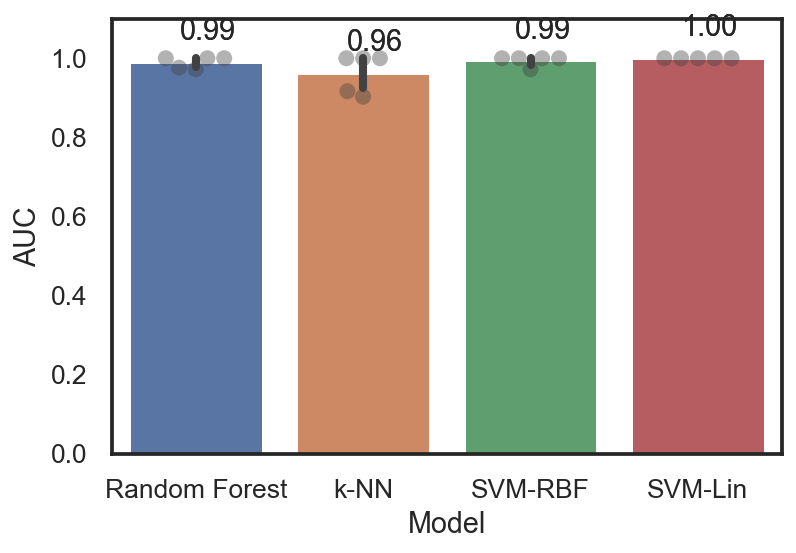

In [33]:
AUCfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'AUC':[mean(RF_AUC), mean(KNN_AUC), mean(clf_AUC), mean(linsvm_AUC)]}

afig = {'RF': RF_AUC, 'KNN': KNN_AUC, 'SVM': clf_AUC, 'Lin-SVM': linsvm_AUC}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(AUCfig, 'AUC');
#plt.title('ML Model AUC Comparison for RCC prediction');

In [34]:
# A function to print out all numeric (and summary of) results
def summary(name, result):
    print ('All Train result for', name, result)
    print ('Summary metric for', name, round(mean(result),2),'+/-', round(np.std(result),2))

In [35]:
summary('Random Forest', RF_AUC)
summary('k-NN', KNN_AUC)
summary('RBF SVM', clf_AUC)
summary('Linear SVM', linsvm_AUC)

All Train result for Random Forest [0.9761904761904763, 1.0, 0.9722222222222222, 1.0, 1.0]
Summary metric for Random Forest 0.99 +/- 0.01
All Train result for k-NN [1.0, 1.0, 0.9027777777777779, 0.9166666666666667, 1.0]
Summary metric for k-NN 0.96 +/- 0.04
All Train result for RBF SVM [1.0, 1.0, 0.9722222222222223, 1.0, 1.0]
Summary metric for RBF SVM 0.99 +/- 0.01
All Train result for Linear SVM [1.0, 1.0, 1.0, 1.0, 1.0]
Summary metric for Linear SVM 1.0 +/- 0.0


**Accuracy**

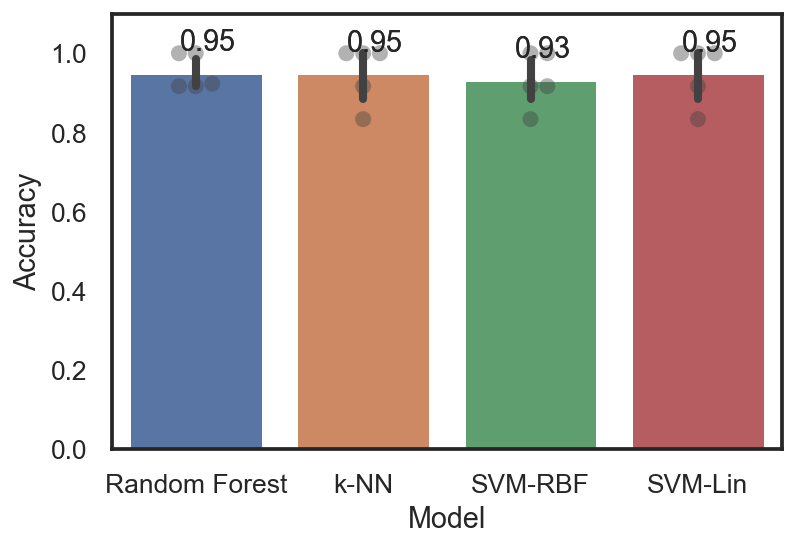

In [36]:
ACC_fig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'Accuracy':[mean(RF_ACC), mean(KNN_ACC), mean(clf_ACC), mean(linsvm_ACC)]}

afig = {'RF': RF_ACC, 'KNN': KNN_ACC, 'SVM': clf_ACC, 'Lin-SVM': linsvm_ACC}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(ACC_fig, 'Accuracy');
#plt.title('ML Model Accuracy Comparison for RCC prediction');

In [37]:
summary('Random Forest', RF_ACC)
summary('k-NN', KNN_ACC)
summary('RBF SVM', clf_ACC)
summary('Linear SVM', linsvm_ACC)

All Train result for Random Forest [0.9230769230769231, 1.0, 0.9166666666666666, 0.9166666666666666, 1.0]
Summary metric for Random Forest 0.95 +/- 0.04
All Train result for k-NN [1.0, 1.0, 0.8333333333333334, 0.9166666666666666, 1.0]
Summary metric for k-NN 0.95 +/- 0.07
All Train result for RBF SVM [1.0, 1.0, 0.8333333333333334, 0.9166666666666666, 0.9166666666666666]
Summary metric for RBF SVM 0.93 +/- 0.06
All Train result for Linear SVM [1.0, 1.0, 0.9166666666666666, 0.8333333333333334, 1.0]
Summary metric for Linear SVM 0.95 +/- 0.07


**Precision**

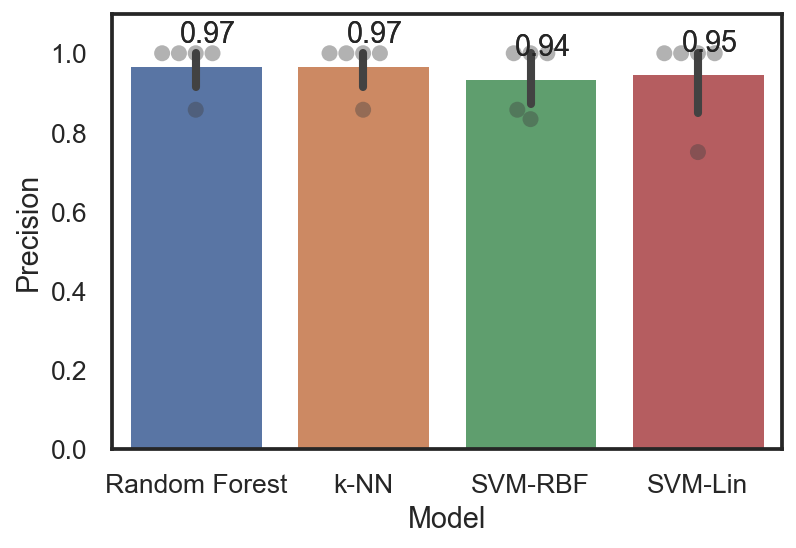

In [38]:
PREfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'Precision':[mean(RF_PRE), mean(KNN_PRE), mean(clf_PRE), mean(linsvm_PRE)]}

afig = {'RF': RF_PRE, 'KNN': KNN_PRE, 'SVM': clf_PRE, 'Lin-SVM': linsvm_PRE}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(PREfig, 'Precision');
#plt.title('ML Model Sensitivity (Precision) Comparison for RCC prediction');

**Recall**

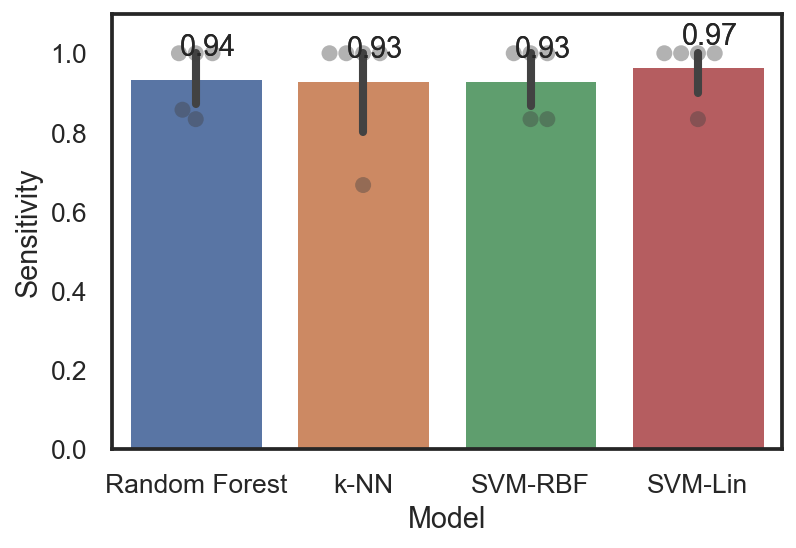

In [39]:
RECfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'Sensitivity':[mean(RF_REC), mean(KNN_REC), mean(clf_REC), mean(linsvm_REC)]}

afig = {'RF': RF_REC, 'KNN': KNN_REC, 'SVM': clf_REC, 'Lin-SVM': linsvm_REC}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(RECfig, 'Sensitivity');
#plt.title('ML Model Specificity (Recall) Comparison for RCC prediction');

In [40]:
summary('Random Forest', RF_REC)
summary('k-NN', KNN_REC)
summary('RBF SVM', clf_REC)
summary('Linear SVM', linsvm_REC)

All Train result for Random Forest [0.8571428571428571, 1.0, 0.8333333333333334, 1.0, 1.0]
Summary metric for Random Forest 0.94 +/- 0.08
All Train result for k-NN [1.0, 1.0, 0.6666666666666666, 1.0, 1.0]
Summary metric for k-NN 0.93 +/- 0.13
All Train result for RBF SVM [1.0, 1.0, 0.8333333333333334, 1.0, 0.8333333333333334]
Summary metric for RBF SVM 0.93 +/- 0.08
All Train result for Linear SVM [1.0, 1.0, 0.8333333333333334, 1.0, 1.0]
Summary metric for Linear SVM 0.97 +/- 0.07


**F1 Score**

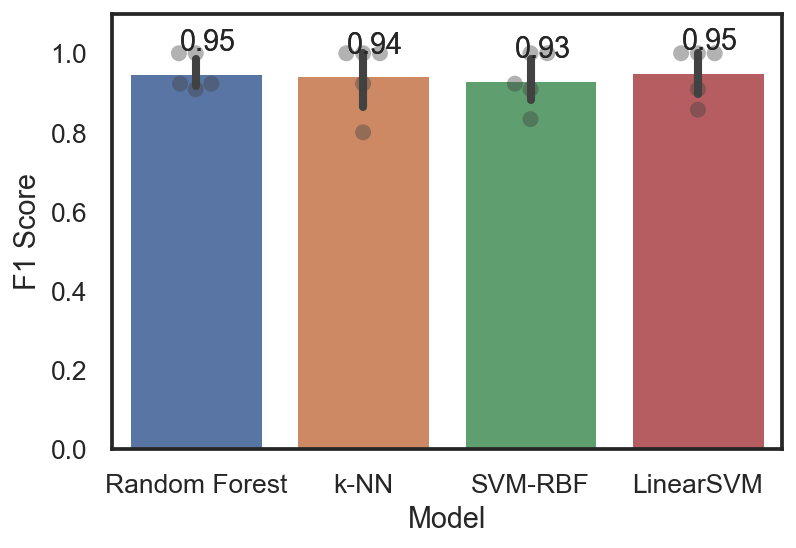

In [41]:
RECfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'LinearSVM'], 
               'F1 Score':[mean(RF_FS), mean(KNN_FS), mean(clf_FS), mean(linsvm_FS)]}

afig = {'RF': RF_FS, 'KNN': KNN_FS, 'SVM': clf_FS, 'Lin-SVM': linsvm_FS}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(RECfig, 'F1 Score');
#plt.title('ML Model F1 Score Comparison for RCC prediction');

**Specificity**

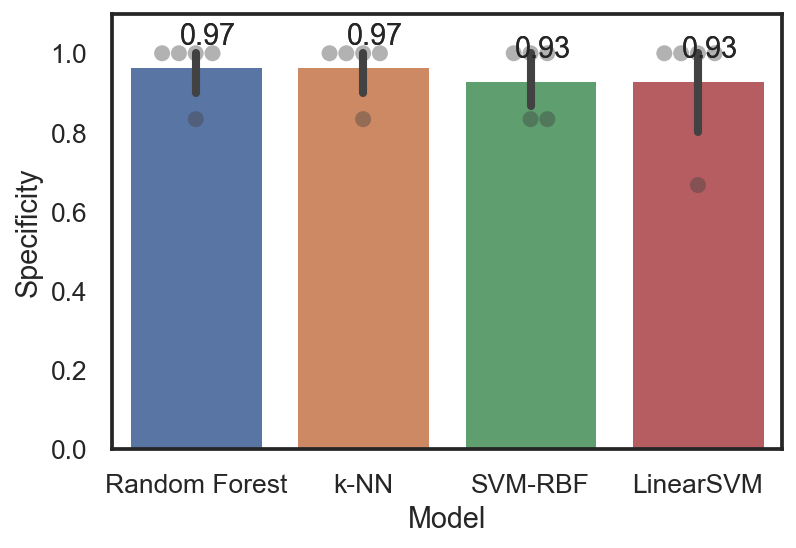

In [42]:
SPEfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'LinearSVM'], 
               'Specificity':[mean(RF_SPE), mean(KNN_SPE), mean(clf_SPE), mean(linsvm_SPE)]}

afig = {'RF': RF_SPE, 'KNN': KNN_SPE, 'SVM': clf_SPE, 'Lin-SVM': linsvm_SPE}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(SPEfig, 'Specificity');
#plt.title('ML Model F1 Score Comparison for RCC prediction');

In [43]:
summary('Random Forest', RF_SPE)
summary('k-NN', KNN_SPE)
summary('RBF SVM', clf_SPE)
summary('Linear SVM', linsvm_SPE)

All Train result for Random Forest [1.0, 1.0, 1.0, 0.8333333333333334, 1.0]
Summary metric for Random Forest 0.97 +/- 0.07
All Train result for k-NN [1.0, 1.0, 1.0, 0.8333333333333334, 1.0]
Summary metric for k-NN 0.97 +/- 0.07
All Train result for RBF SVM [1.0, 1.0, 0.8333333333333334, 0.8333333333333334, 1.0]
Summary metric for RBF SVM 0.93 +/- 0.08
All Train result for Linear SVM [1.0, 1.0, 1.0, 0.6666666666666666, 1.0]
Summary metric for Linear SVM 0.93 +/- 0.13


### Chemical Information of the Biomarkers

In [44]:
# Import MS_labels
MS_labels = pd.read_excel('data/MS_labels.xlsx', index_col=0)

In [45]:
MS_labels[MS_labels.ID.isin(MLfeatures.columns)]

,ID,Mode,RT [min],Name,Formula


In [46]:
feature_imp = pd.Series(RF.feature_importances_,
                        index=MLfeatures.columns).sort_values(ascending=False)

No handles with labels found to put in legend.


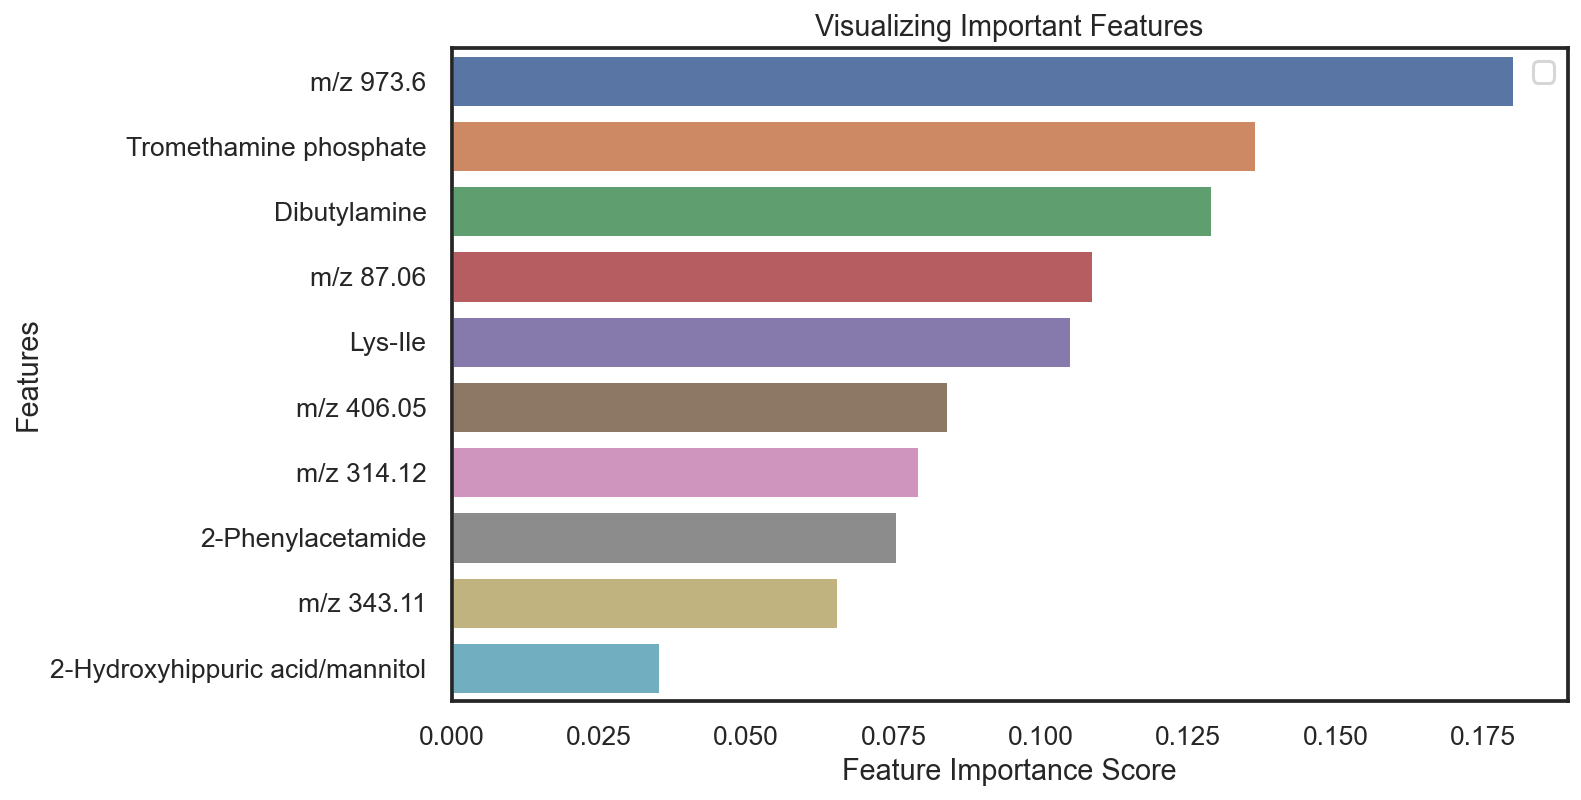

In [47]:
feature_imp = pd.Series(RF.feature_importances_,
                        index=MLfeatures.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
#plt.savefig('RF_Features.svg', dpi=300)
plt.show()

### Potential Biomarkers: PCA, HCA, Boxplot Visualization

In [48]:
#biomarker_feat = dummydf[df_feat['Metabolites']]
#biomarker_feat =(biomarker_feat - biomarker_feat.mean(axis=0))/biomarker_feat.std(axis=0)
group_loc = modelcohort.columns.get_loc("Groups") #autoscaling
biomarker =  modelcohort.iloc[:, group_loc].to_frame().join(MLfeatures)

**p and q values associated with the metabolite panel in the model cohort**

In [49]:
stat_sig[stat_sig.Metabolite.isin(biomarker.columns)]

,Metabolite,T-test p-value,FDR p-value,Reject H0
815,Dibutylamine,7.480753e-08,0.000157,True
1374,m/z 973.6,2.707590e-07,0.000285,True
1321,m/z 87.06,4.976800e-07,0.000349,True
283,2-Phenylacetamide,1.466276e-06,0.000441,True
1880,m/z 314.12,1.048271e-06,0.000441,True
1430,m/z 406.05,2.719035e-06,0.000554,True
1881,2-Hydroxyhippuric acid/mannitol,3.088222e-06,0.000554,True
1354,Tromethamine phosphate,4.246283e-06,0.000558,True
1150,m/z 343.11,2.945719e-05,0.001240,True
593,Lys-Ile,4.260921e-05,0.001362,True


**Boxplot**

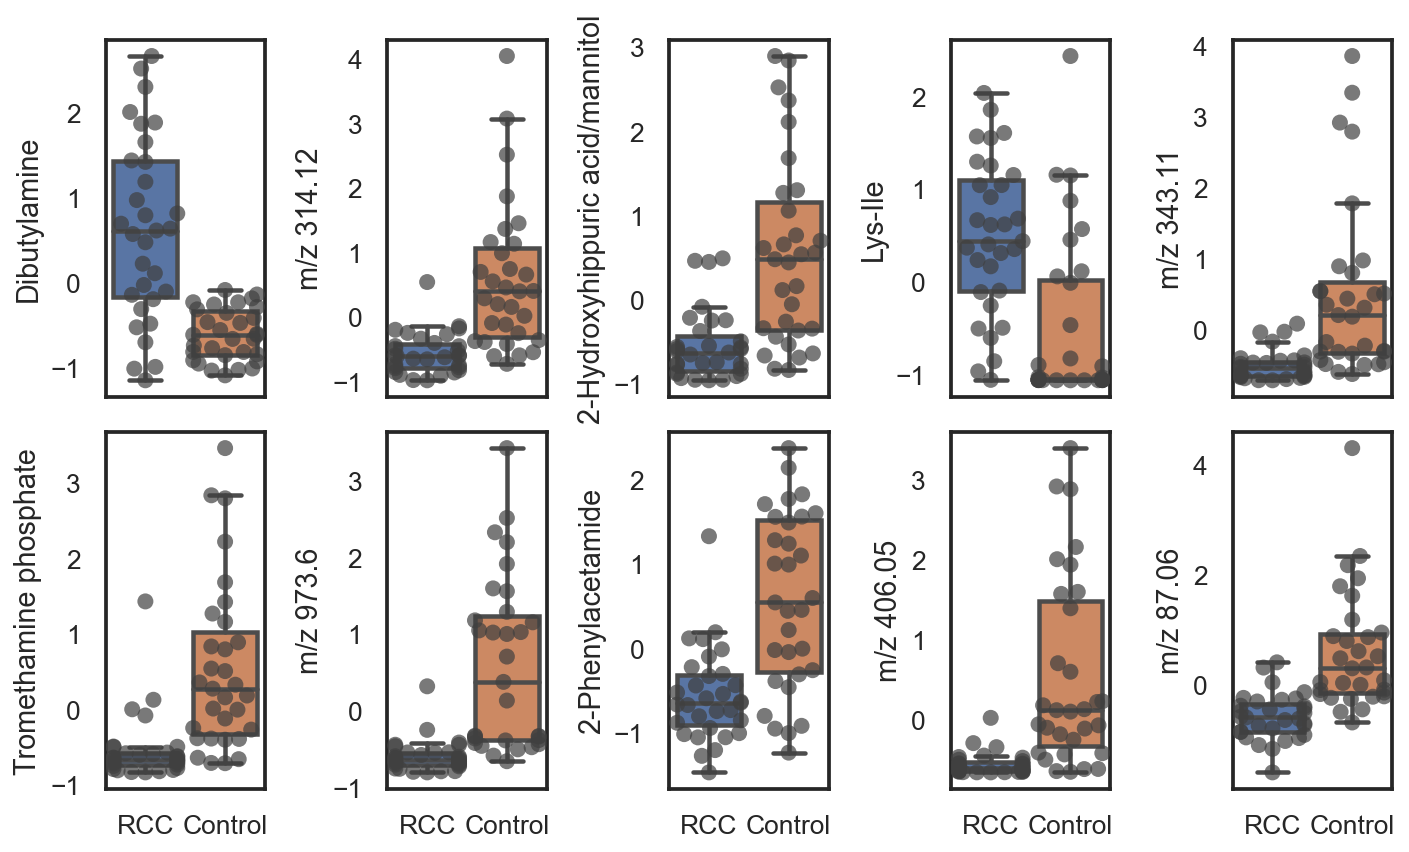

In [50]:
# Metabolites Quantification via boxplot or barplot
fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, figsize=(10, 6))
for idx, feat in enumerate(biomarker.columns[1:]):
    ax = axes[int(idx / 5), idx % 5]
    sns.boxplot(x='Groups', y=feat, data=biomarker, 
                ax=ax, showfliers=False)
    #sns.barplot (x='Groups', y=feat, data=df, ax=ax, capsize=.06)
    sns.swarmplot(x='Groups', y=feat, data=biomarker, 
                  ax=ax, s=8, alpha=0.7, color=".25");
    ax.set_xlabel('')
    ax.set_ylabel(feat) #feat
fig.tight_layout();
#plt.savefig('AUCplots.svg', dpi=300)

**PCA**

In [51]:
def PCA_Python(X, y, scaled=True):
    '''
    FUNCTION:  
    A principle component analysis function
    Note that number of component to be picked is fixed at 2 and scaling is pareto. 
    **Edit function to make this flexible** 
    
    DEPENDENCY: sklearn
    from sklearn import decomposition
    
    INPUT: Pandas dataframe
    X: Data. Numerical.
    y: Groups
    scaled: Boolean. Default=True
   
    
    OUTPUT: figure
    A PCA score plot
    
    '''
    pca = decomposition.PCA(n_components=2)
    if scaled == True: 
        X_centered = (X - X.mean(axis=0))/np.sqrt(X.std(axis=0)) # pareto scaling.
        #X_centered =(X - X.mean(axis=0))/X.std(axis=0) #autoscaling
    elif scaled == False:
        X_centered = X
    
    pca.fit(X_centered)
    X_pca = pca.transform(X_centered)
    Var = pca.explained_variance_ratio_ # returns variance ratio of the selected component. 
    a = plt.plot(X_pca[y == 0, 0], X_pca[y == 0, 1], 'bo', label='Control');
    b = plt.plot(X_pca[y == 1, 0], X_pca[y == 1, 1], 'ro', label='RCC');
    c = plt.xlabel("PC1: " + str(round(Var[0]*100, 2)) + "%");
    d = plt.ylabel("PC2: " + str(round(Var[1]*100, 2))+ "%");
    e = plt.legend(loc=0);
    return (a, b, c, d, e)

PCA score plots using all ML features

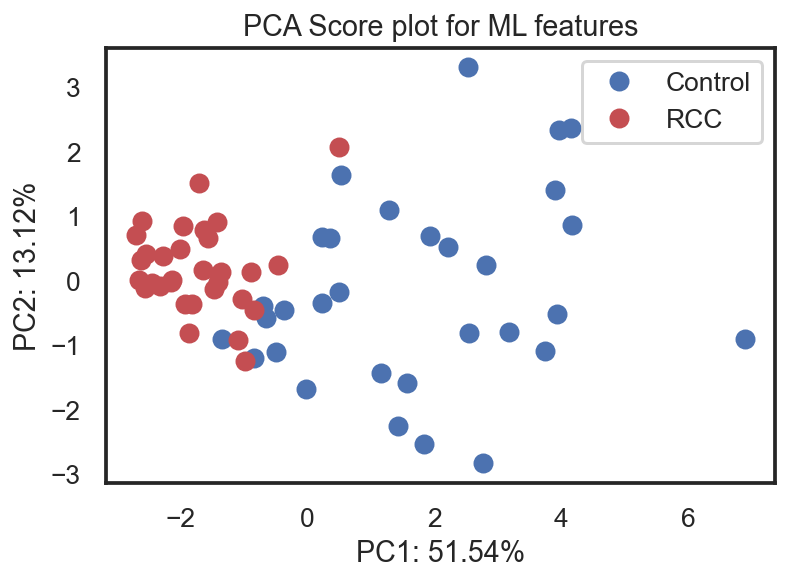

In [52]:
ylabel = biomarker['Groups'].map({'Control' : 0, 'RCC' : 1})
PCA_Python(MLfeatures, ylabel, False)
plt.title('PCA Score plot for ML features');

**Hierarchial Clustering using all ML features**

In [53]:
group_loc = modelcohort.columns.get_loc("Groups") #autoscaling
biomarker =  modelcohort.iloc[:, group_loc].to_frame().join(MLfeatures)

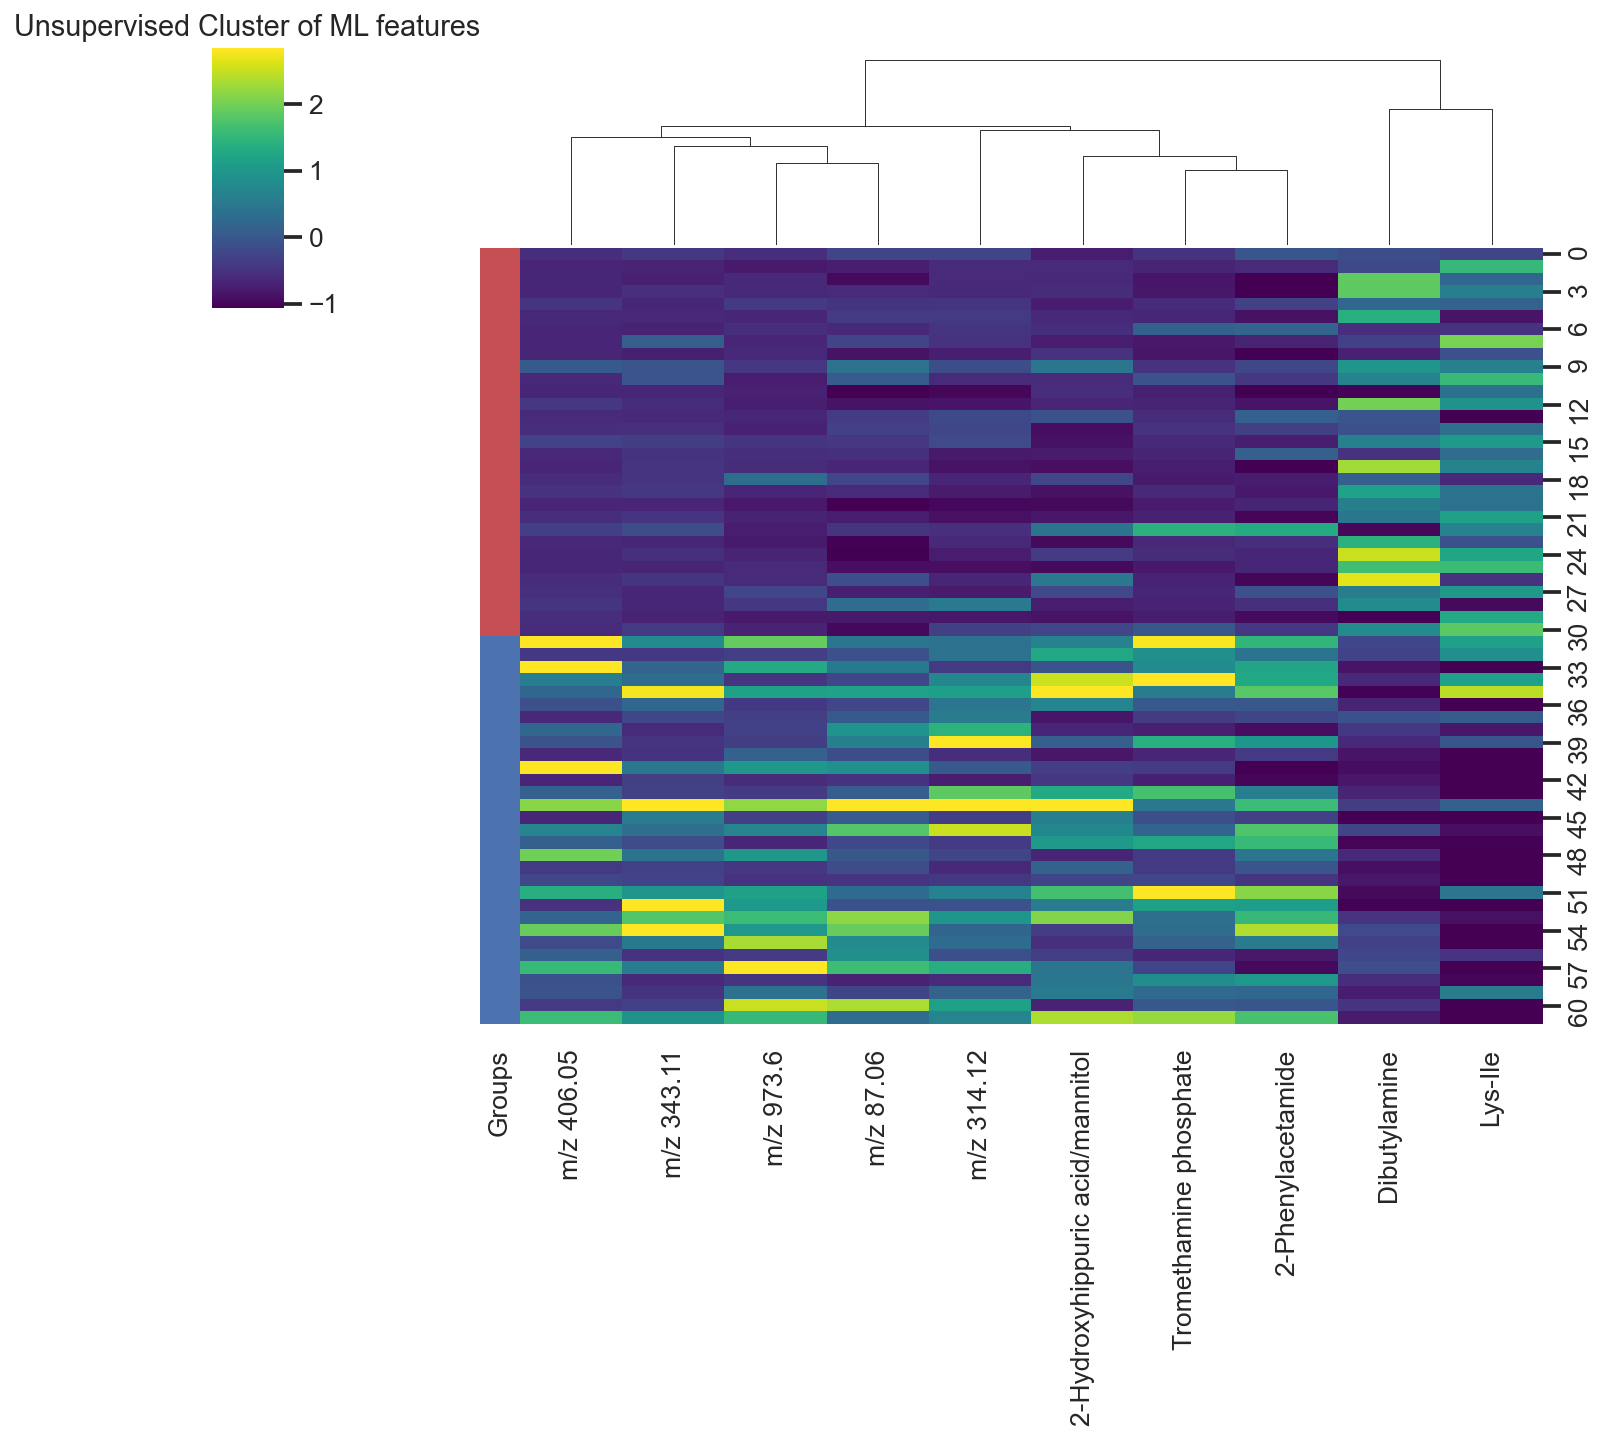

In [54]:
groups_two = biomarker.pop('Groups')
biomarker = biomarker.astype(float)
lut = dict(zip(groups_two.unique(), 'rbg'))
row_colors = groups_two.map(lut)
sns.clustermap(biomarker, method="weighted", 
                   metric='euclidean', cmap="viridis", row_cluster=False, 
                   row_colors=row_colors, robust=True);
plt.title('Unsupervised Cluster of ML features');
# define biomarker dataframe again because of the .pop method
biomarker =  modelcohort.iloc[:, group_loc].to_frame().join(MLfeatures)

**Hierarchial Clustering using features with _q_ value < 0.05**

In [55]:
Feature = stat_sig['Metabolite'].values.tolist(); # stat MS significant metabolites
qfeatures = NMRMS[Feature] # p<0.05 metabolites
qfeatures =(qfeatures - qfeatures.mean(axis=0))/qfeatures.std(axis=0) #autoscaling
group_loc = modelcohort.columns.get_loc("Groups") #autoscaling
qmarker = modelcohort.iloc[:, group_loc].to_frame().join(qfeatures)
print ('The total number of features in this DF is:', len(Feature))

The total number of features in this DF is: 435


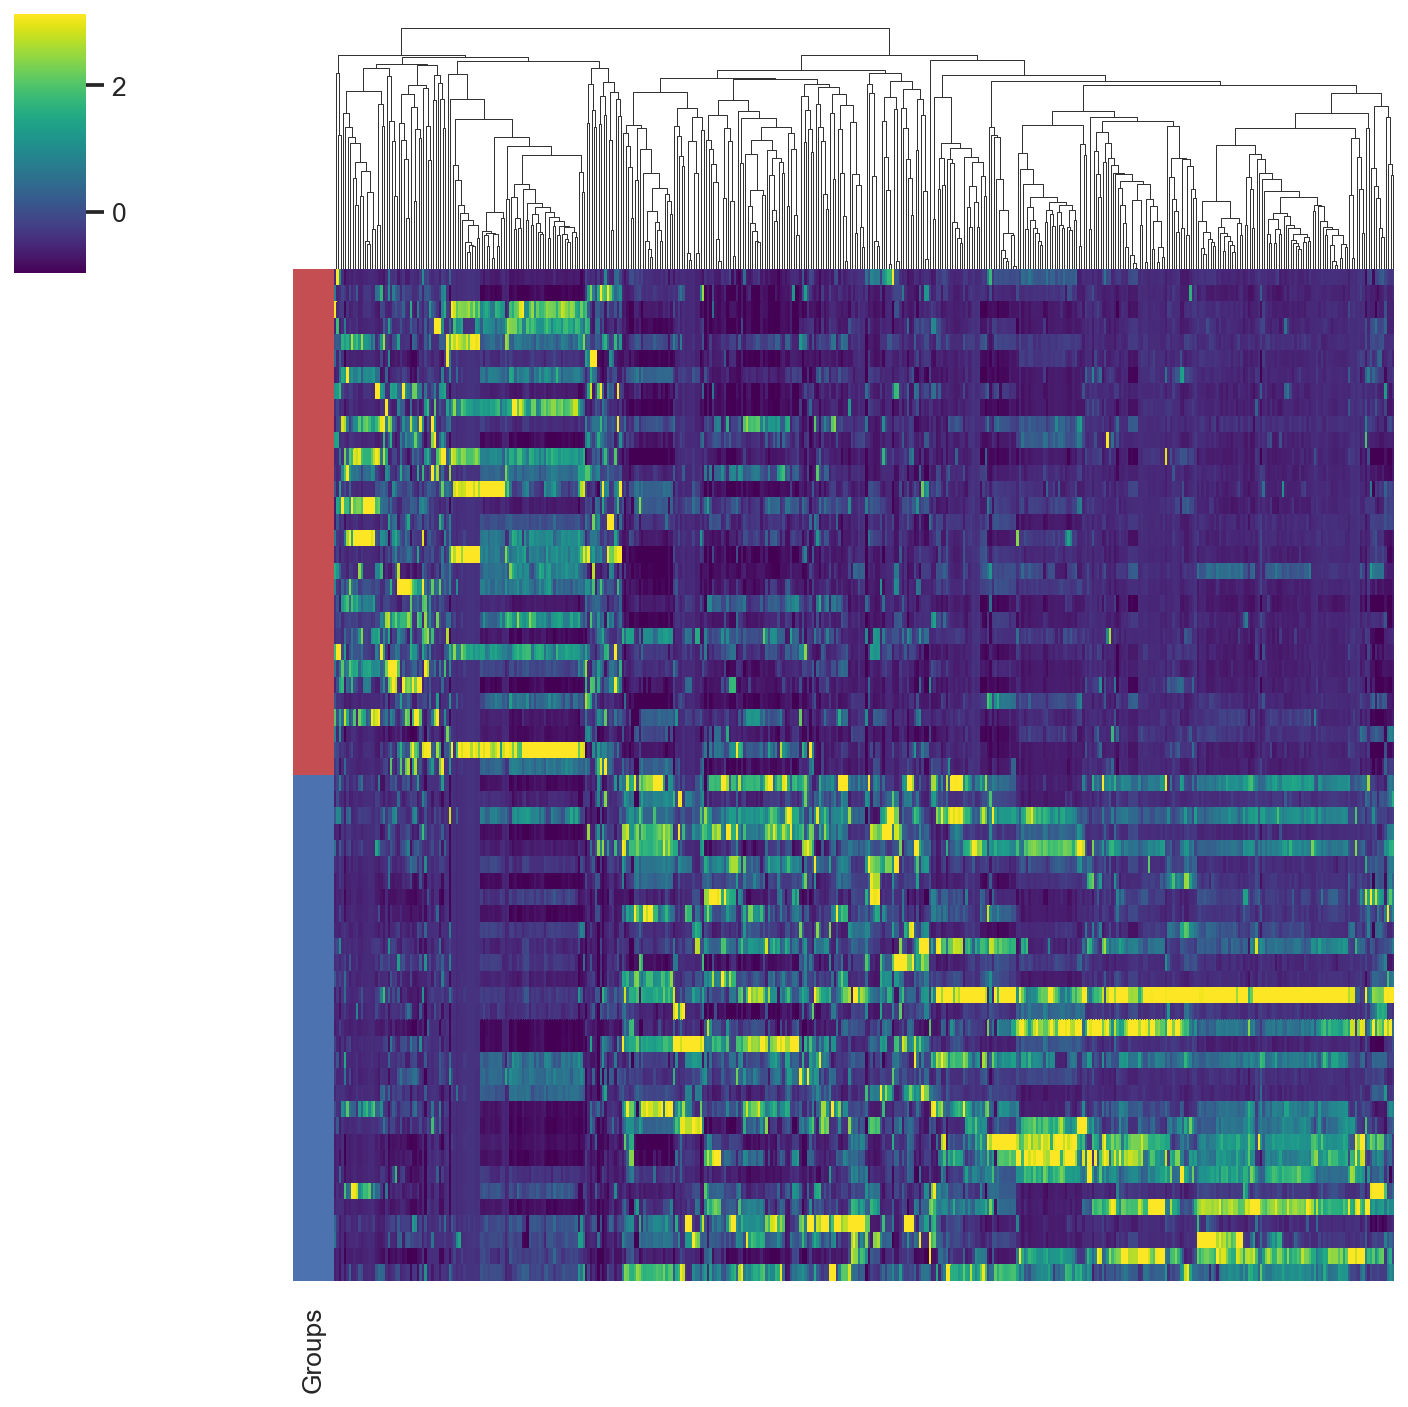

In [56]:
groups_two = qmarker.pop('Groups')
qmarker = qmarker.astype(float)
lut = dict(zip(groups_two.unique(), 'rbg'))
row_colors = groups_two.map(lut)
hca_qmarker = sns.clustermap(qmarker, method="weighted", 
               metric='euclidean', cmap="viridis", 
               row_cluster=False, row_colors=row_colors, 
               robust=True, xticklabels=False, 
               yticklabels=False);
#plt.title('Unsupervised Cluster of ML features');

#save figure
#hca_qmarker.savefig("hca_qmarker.svg")
# define biomarker dataframe again because of the .pop method
qmarker = modelcohort.iloc[:, group_loc].to_frame().join(qfeatures)

## 3. RCC Classification: Test Cohort
<a id="3"></a>

In [57]:
testcohort = pd.read_excel('data/testcohort.xlsx', index_col=0)

testcohort.rename(columns={720:'2-Phenylacetamide', 1481:'Lys-Ile',
                          2102:'Dibutylamine', 3141:'m/z 343.11',
                         3675:'m/z 87.06', 3804:'Tromethamine phosphate',
                         3872:'m/z 973.6', 4080:'m/z 406.05',
                         6261:'m/z 314.12', 6262:'2-Hydroxyhippuric acid/mannitol'}, 
                 inplace=True)

MLfeatures2 = testcohort[biomarker.iloc[:, 1:].columns]
MLfeatures2 =(MLfeatures2 - MLfeatures2.mean(axis=0))/MLfeatures2.std(axis=0) #autoscaling
MLfeatures2.shape

(194, 10)

In [58]:
# define features and label.
dfgrp = testcohort.filter(['Groups'], axis=1)
#convert strings (RCC, Control) to integers
dfgroup = dfgrp['Groups'].map({'Control': 0, 'RCC': 1}) 
X = MLfeatures2.values
y = dfgroup.values
print (X.shape)
print (y.shape)

(194, 10)
(194,)


### Call the tuned machine learning algorithms

In [59]:
print(RF)
print(linsvm)
print(clf)
print(knn)

RandomForestClassifier(max_depth=10, random_state=42)
SVC(C=0.1, kernel='linear', probability=True, random_state=42)
SVC(C=10, gamma=0.1, probability=True, random_state=42)
KNeighborsClassifier(n_neighbors=4, p=1)


In [60]:
#RF=RandomForestClassifier(n_estimators=100, random_state=123)
metric = ml_model(X, y, RF)
RF_AUC, RF_ACC, RF_PRE, RF_REC, RF_FS, RF_MCC, RF_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]

# Linear-SVM
metric = ml_model(X, y, linsvm)
linsvm_AUC, linsvm_ACC, linsvm_PRE, linsvm_REC, linsvm_FS, linsvm_MCC, linsvm_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]

# SVM
#clf = svm.SVC(kernel='linear', probability=True)
metric = ml_model(X, y, clf)
clf_AUC, clf_ACC, clf_PRE, clf_REC, clf_FS, clf_MCC, clf_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]

# KNN
metric = ml_model(X, y, knn)
KNN_AUC, KNN_ACC, KNN_PRE, KNN_REC, KNN_FS, KNN_MCC, KNN_SPE = metric[0], metric[1], metric[2], metric[3], metric[4], metric[5], metric[6]

**AUC**

In [61]:
sns.set_context('talk', font_scale=0.8)

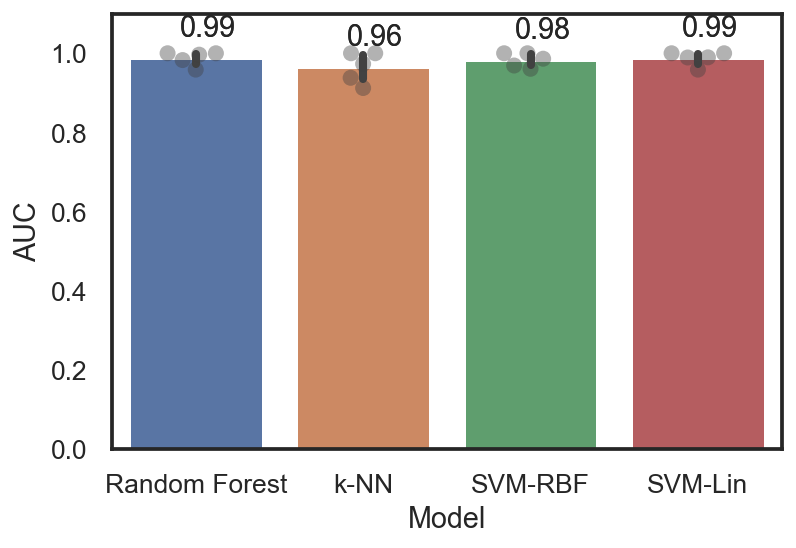

In [62]:
AUCfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'AUC':[mean(RF_AUC), mean(KNN_AUC), mean(clf_AUC), mean(linsvm_AUC)]}

afig = {'RF': RF_AUC, 'KNN': KNN_AUC, 'SVM': clf_AUC, 'Lin-SVM': linsvm_AUC}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(AUCfig, 'AUC');
#plt.title('ML Model AUC Comparison for RCC prediction');

In [63]:
summary('Random Forest', RF_AUC)
summary('k-NN', KNN_AUC)
summary('RBF SVM', clf_AUC)
summary('Linear SVM', linsvm_AUC)

All Train result for Random Forest [1.0, 0.9586206896551723, 1.0, 0.9827586206896551, 0.9964285714285714]
Summary metric for Random Forest 0.99 +/- 0.02
All Train result for k-NN [1.0, 0.9120689655172414, 1.0, 0.9379310344827585, 0.9732142857142857]
Summary metric for k-NN 0.96 +/- 0.03
All Train result for RBF SVM [1.0, 0.9689655172413792, 1.0, 0.9862068965517241, 0.9607142857142856]
Summary metric for RBF SVM 0.98 +/- 0.02
All Train result for Linear SVM [1.0, 0.9586206896551723, 1.0, 0.9896551724137931, 0.9892857142857143]
Summary metric for Linear SVM 0.99 +/- 0.02


**Accuracy**

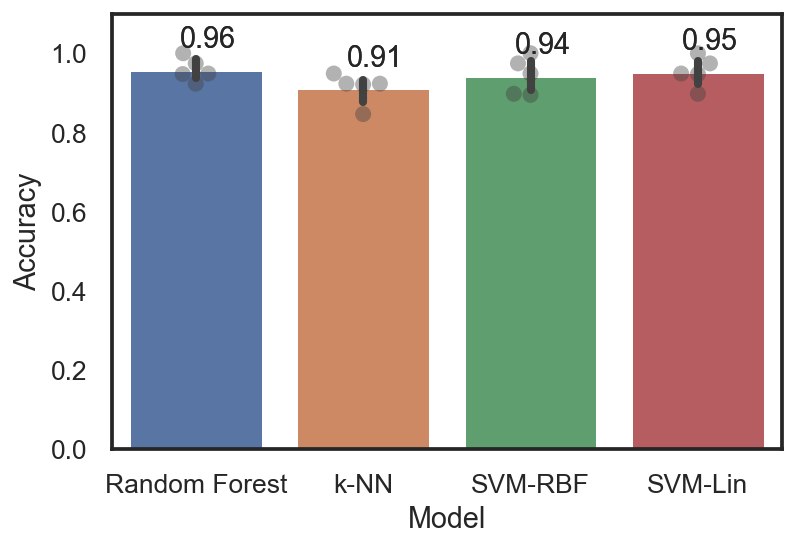

In [64]:
ACC_fig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'Accuracy':[mean(RF_ACC), mean(KNN_ACC), mean(clf_ACC), mean(linsvm_ACC)]}

afig = {'RF': RF_ACC, 'KNN': KNN_ACC, 'SVM': clf_ACC, 'Lin-SVM': linsvm_ACC}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(ACC_fig, 'Accuracy');
#plt.title('ML Model Accuracy Comparison for RCC prediction');

In [65]:
summary('Random Forest', RF_ACC)
summary('k-NN', KNN_ACC)
summary('RBF SVM', clf_ACC)
summary('Linear SVM', linsvm_ACC)

All Train result for Random Forest [0.9743589743589743, 0.9230769230769231, 1.0, 0.9487179487179487, 0.9473684210526315]
Summary metric for Random Forest 0.96 +/- 0.03
All Train result for k-NN [0.9230769230769231, 0.8461538461538461, 0.9487179487179487, 0.9230769230769231, 0.9210526315789473]
Summary metric for k-NN 0.91 +/- 0.03
All Train result for RBF SVM [0.9743589743589743, 0.8974358974358975, 1.0, 0.9487179487179487, 0.8947368421052632]
Summary metric for RBF SVM 0.94 +/- 0.04
All Train result for Linear SVM [0.9487179487179487, 0.8974358974358975, 1.0, 0.9743589743589743, 0.9473684210526315]
Summary metric for Linear SVM 0.95 +/- 0.03


**Precision**

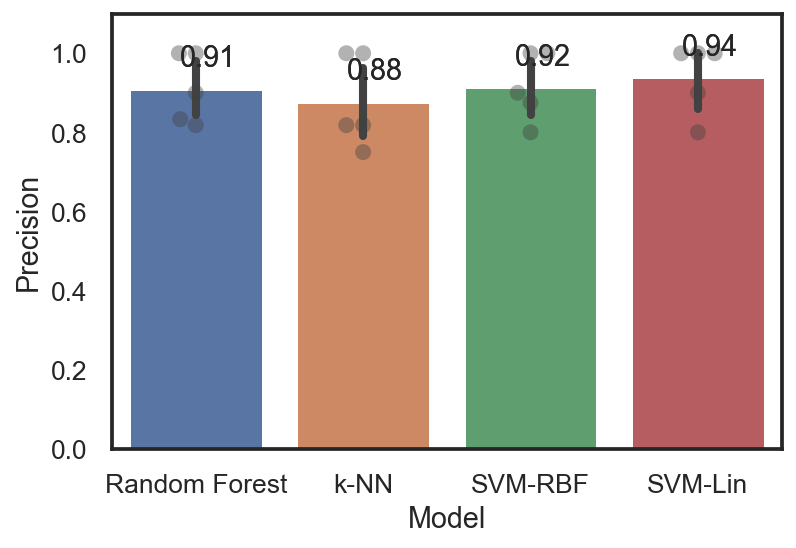

In [66]:
PREfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'Precision':[mean(RF_PRE), mean(KNN_PRE), mean(clf_PRE), mean(linsvm_PRE)]}

afig = {'RF': RF_PRE, 'KNN': KNN_PRE, 'SVM': clf_PRE, 'Lin-SVM': linsvm_PRE}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(PREfig, 'Precision');
#plt.title('ML Model Sensitivity (Precision) Comparison for RCC prediction');

**Recall**

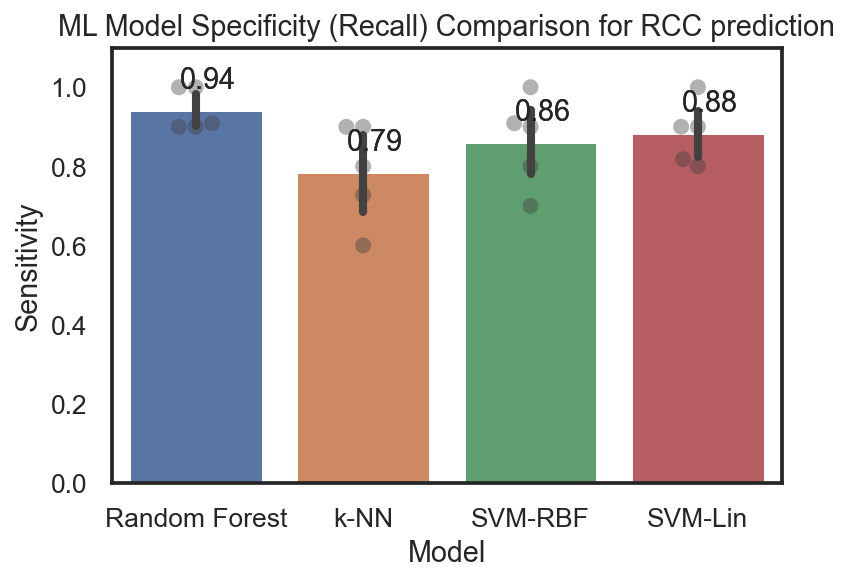

In [67]:
RECfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'SVM-Lin'], 
               'Sensitivity':[mean(RF_REC), mean(KNN_REC), mean(clf_REC), mean(linsvm_REC)]}

afig = {'RF': RF_REC, 'KNN': KNN_REC, 'SVM': clf_REC, 'Lin-SVM': linsvm_REC}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(RECfig, 'Sensitivity');
plt.title('ML Model Specificity (Recall) Comparison for RCC prediction');

In [68]:
summary('Random Forest', RF_REC)
summary('k-NN', KNN_REC)
summary('RBF SVM', clf_REC)
summary('Linear SVM', linsvm_REC)

All Train result for Random Forest [0.9090909090909091, 0.9, 1.0, 0.9, 1.0]
Summary metric for Random Forest 0.94 +/- 0.05
All Train result for k-NN [0.7272727272727273, 0.6, 0.8, 0.9, 0.9]
Summary metric for k-NN 0.79 +/- 0.11
All Train result for RBF SVM [0.9090909090909091, 0.7, 1.0, 0.9, 0.8]
Summary metric for RBF SVM 0.86 +/- 0.1
All Train result for Linear SVM [0.8181818181818182, 0.8, 1.0, 0.9, 0.9]
Summary metric for Linear SVM 0.88 +/- 0.07


**F1 Score**

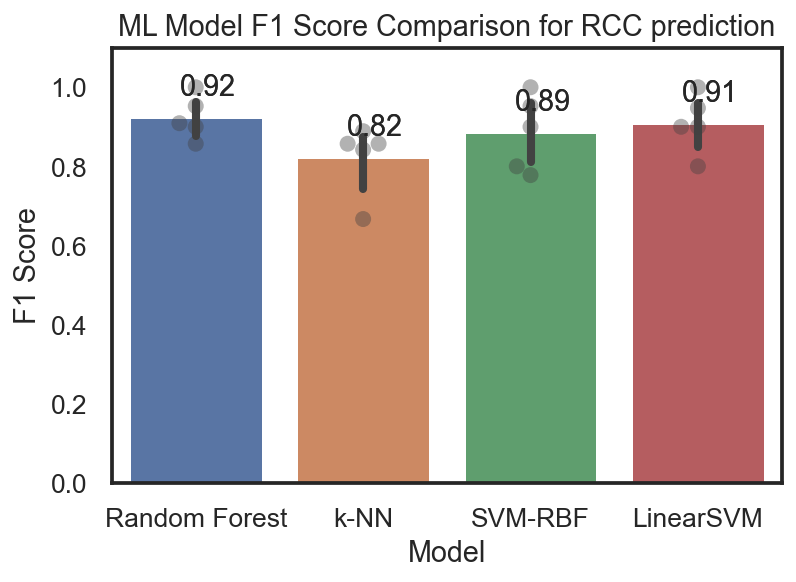

In [69]:
RECfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'LinearSVM'], 
               'F1 Score':[mean(RF_FS), mean(KNN_FS), mean(clf_FS), mean(linsvm_FS)]}

afig = {'RF': RF_FS, 'KNN': KNN_FS, 'SVM': clf_FS, 'Lin-SVM': linsvm_FS}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(RECfig, 'F1 Score');
plt.title('ML Model F1 Score Comparison for RCC prediction');

**Specificity**

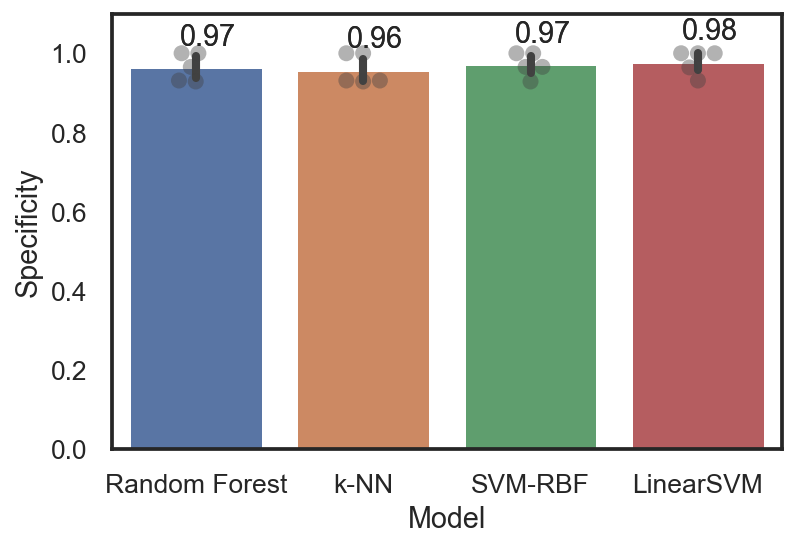

In [70]:
SPEfig = {'Model': ['Random Forest', 'k-NN', 'SVM-RBF', 'LinearSVM'], 
               'Specificity':[mean(RF_SPE), mean(KNN_SPE), mean(clf_SPE), mean(linsvm_SPE)]}

afig = {'RF': RF_SPE, 'KNN': KNN_SPE, 'SVM': clf_SPE, 'Lin-SVM': linsvm_SPE}
bafig = pd.DataFrame(afig)
sns.barplot(data=bafig)
sns.swarmplot(data=bafig,s=8, alpha=0.4, color=".25")
plt.ylim(0,1.1)

MLmetric_plot(SPEfig, 'Specificity');
#plt.title('ML Model F1 Score Comparison for RCC prediction');

In [71]:
summary('Random Forest', RF_SPE)
summary('k-NN', KNN_SPE)
summary('RBF SVM', clf_SPE)
summary('Linear SVM', linsvm_SPE)

All Train result for Random Forest [1.0, 0.9310344827586207, 1.0, 0.9655172413793104, 0.9285714285714286]
Summary metric for Random Forest 0.97 +/- 0.03
All Train result for k-NN [1.0, 0.9310344827586207, 1.0, 0.9310344827586207, 0.9285714285714286]
Summary metric for k-NN 0.96 +/- 0.03
All Train result for RBF SVM [1.0, 0.9655172413793104, 1.0, 0.9655172413793104, 0.9285714285714286]
Summary metric for RBF SVM 0.97 +/- 0.03
All Train result for Linear SVM [1.0, 0.9310344827586207, 1.0, 1.0, 0.9642857142857143]
Summary metric for Linear SVM 0.98 +/- 0.03


One of the best classifier is RF, and here are the feature importance from random forest:

No handles with labels found to put in legend.


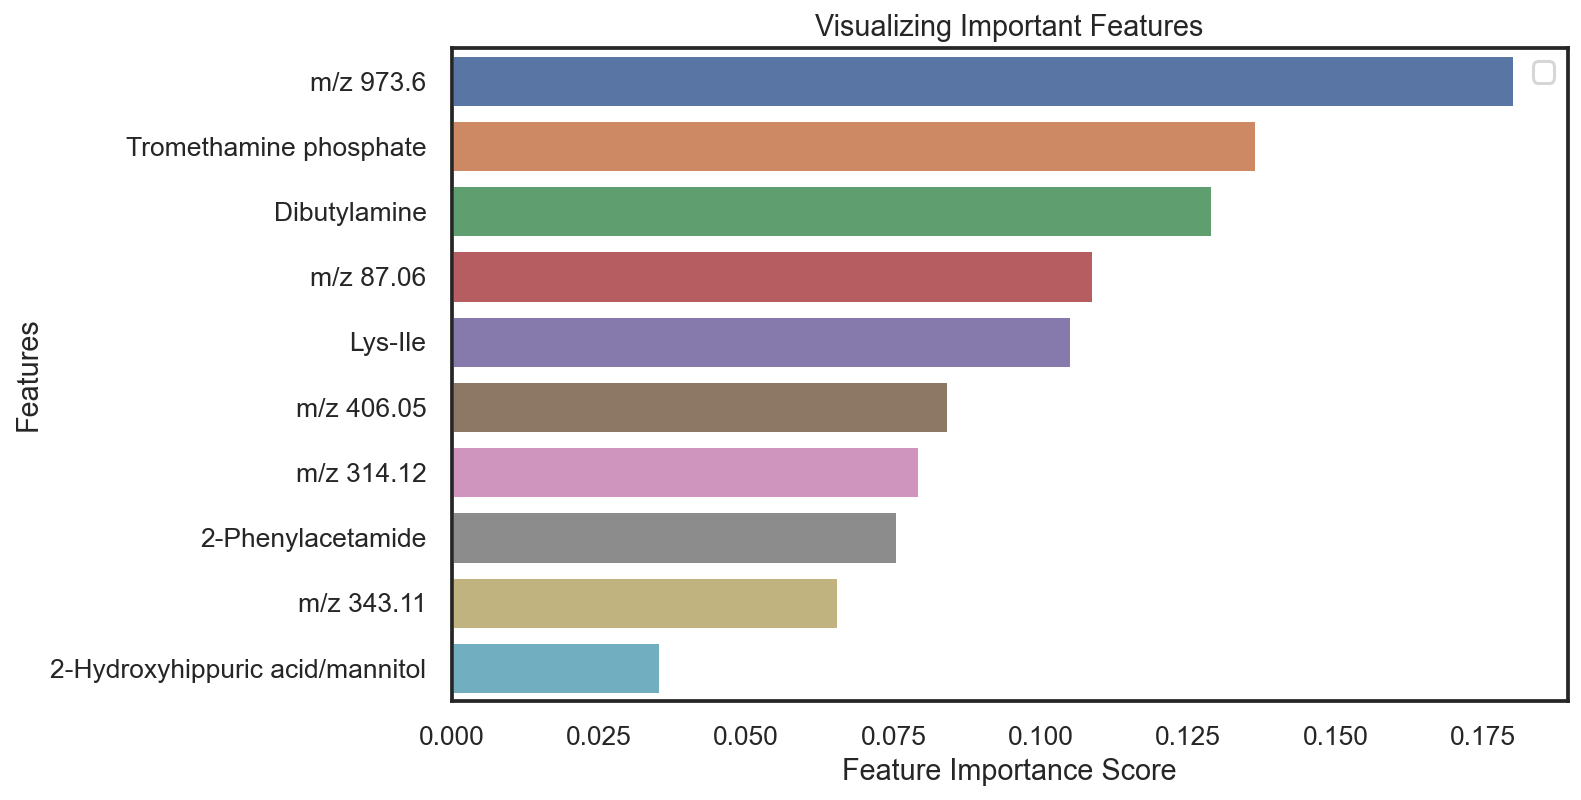

In [72]:
plt.figure(figsize=(10,6))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
#plt.savefig('RF_Features.svg', dpi=300)
plt.show()

### Biomarkers: PCA, Hierarchical clustering and Boxplot Visualization

In [73]:
print (testcohort.shape)
print (MLfeatures2.shape)

(194, 7155)
(194, 10)


In [74]:
group_loc = testcohort.columns.get_loc("Groups") #autoscaling
biomarker2 =  testcohort.iloc[:, group_loc].to_frame().join(MLfeatures2)
biomarker2.shape

(194, 11)

**_T_-test for metabolic features in the test cohort**

In [75]:
# Select the metabolic feature panel for RCC
MLfeatures2 = testcohort[biomarker.iloc[:, 1:].columns]
# Get the 'group' location
group_loc = testcohort.columns.get_loc("Groups") 
# Join group with the metabolic feature panel for RCC
biomarker_TC =  testcohort.iloc[:, group_loc].to_frame().join(MLfeatures2)
# Build biomarker dataframe for Controls and RCC
Control_TC = biomarker_TC[(biomarker_TC['Groups'] == 'Control')]
RCC_TC = biomarker_TC[(biomarker_TC['Groups'] == 'RCC')]
# drop groups from the biomarker_TC columns
biomarker_TC.drop(['Groups'], axis=1, inplace=True)

In [76]:
ttest_result2 = Ttest(biomarker_TC.columns, Control_TC, 
                      RCC_TC, alpha=0.05, var=False)
ttest_result2

,Metabolite,T-test p-value,FDR p-value,Reject H0
8,m/z 406.05,1.357455e-19,1.357455e-18,True
7,2-Phenylacetamide,6.107402e-18,3.053701e-17,True
1,m/z 314.12,1.002511e-14,3.341703e-14,True
0,Dibutylamine,6.805514e-11,1.701378e-10,True
2,2-Hydroxyhippuric acid/mannitol,1.956155e-10,3.912311e-10,True
5,Tromethamine phosphate,2.783971e-09,3.977101e-09,True
9,m/z 87.06,2.432332e-09,3.977101e-09,True
3,Lys-Ile,3.639234e-07,4.549042e-07,True
4,m/z 343.11,1.074027e-06,1.193363e-06,True
6,m/z 973.6,3.734687e-04,3.734687e-04,True


Boxplot

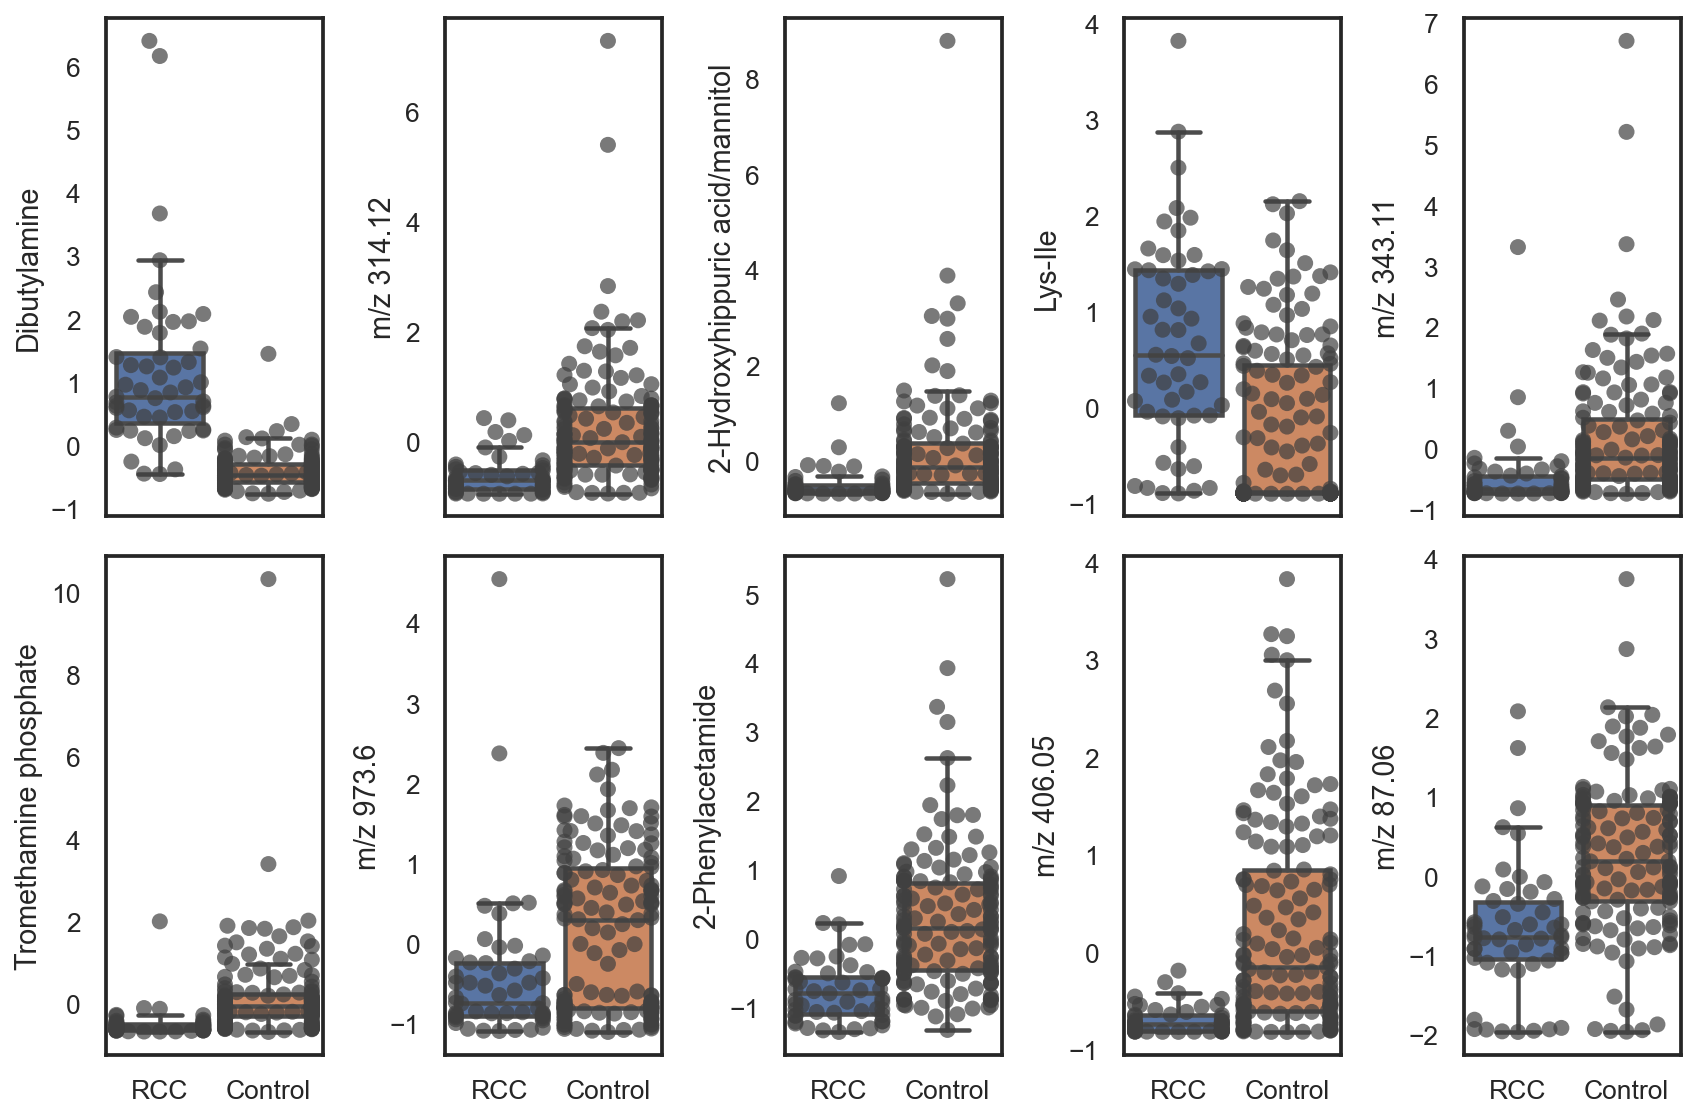

In [77]:
# Metabolites Quantification via boxplot or barplot
fig, axes = plt.subplots(nrows=2, ncols=5, sharex=True, figsize=(12, 8))
for idx, feat in enumerate(biomarker2.columns[1:]):
    ax = axes[int(idx / 5), idx % 5]
    sns.boxplot(x='Groups', y=feat, data=biomarker2, ax=ax, showfliers=False)
    #sns.barplot (x='Groups', y=feat, data=df, ax=ax, capsize=.06)
    sns.swarmplot(x='Groups', y=feat, data=biomarker2, 
                  ax=ax, s=8, alpha=0.7, color=".25");
    ax.set_xlabel('')
    ax.set_ylabel(feat) #feat
fig.tight_layout();
#plt.savefig('AUCplots2.svg', dpi=300)

**PCA score plots using all ML features**

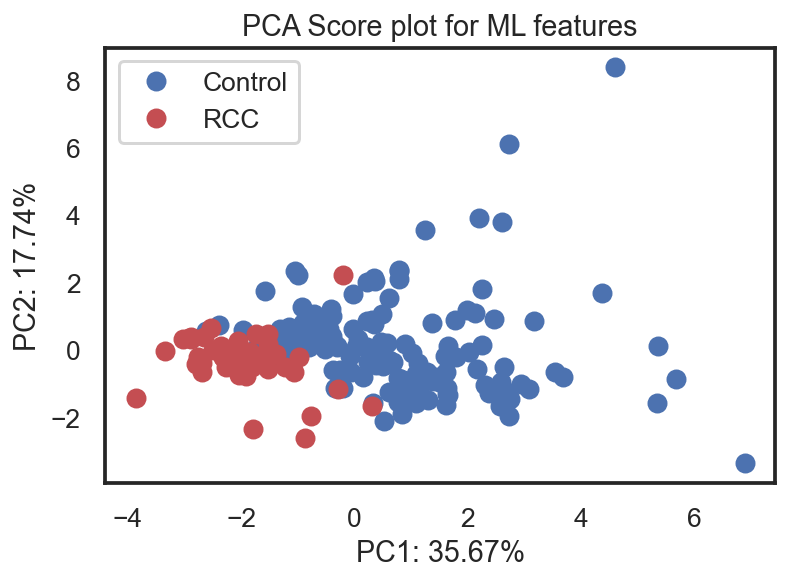

In [78]:
ylabel = biomarker2['Groups'].map({'Control' : 0, 'RCC' : 1})
MLfeatures2 =(MLfeatures2 - MLfeatures2.mean(axis=0))/MLfeatures2.std(axis=0) #autoscaling
PCA_Python(MLfeatures2, ylabel, False)
plt.title('PCA Score plot for ML features');

**Hierarchial Clustering using all ML features**

In [79]:
group_loc = testcohort.columns.get_loc("Groups") #autoscaling
biomarker2 =  testcohort.iloc[:, group_loc].to_frame().join(MLfeatures2)
biomarker2.shape

(194, 11)

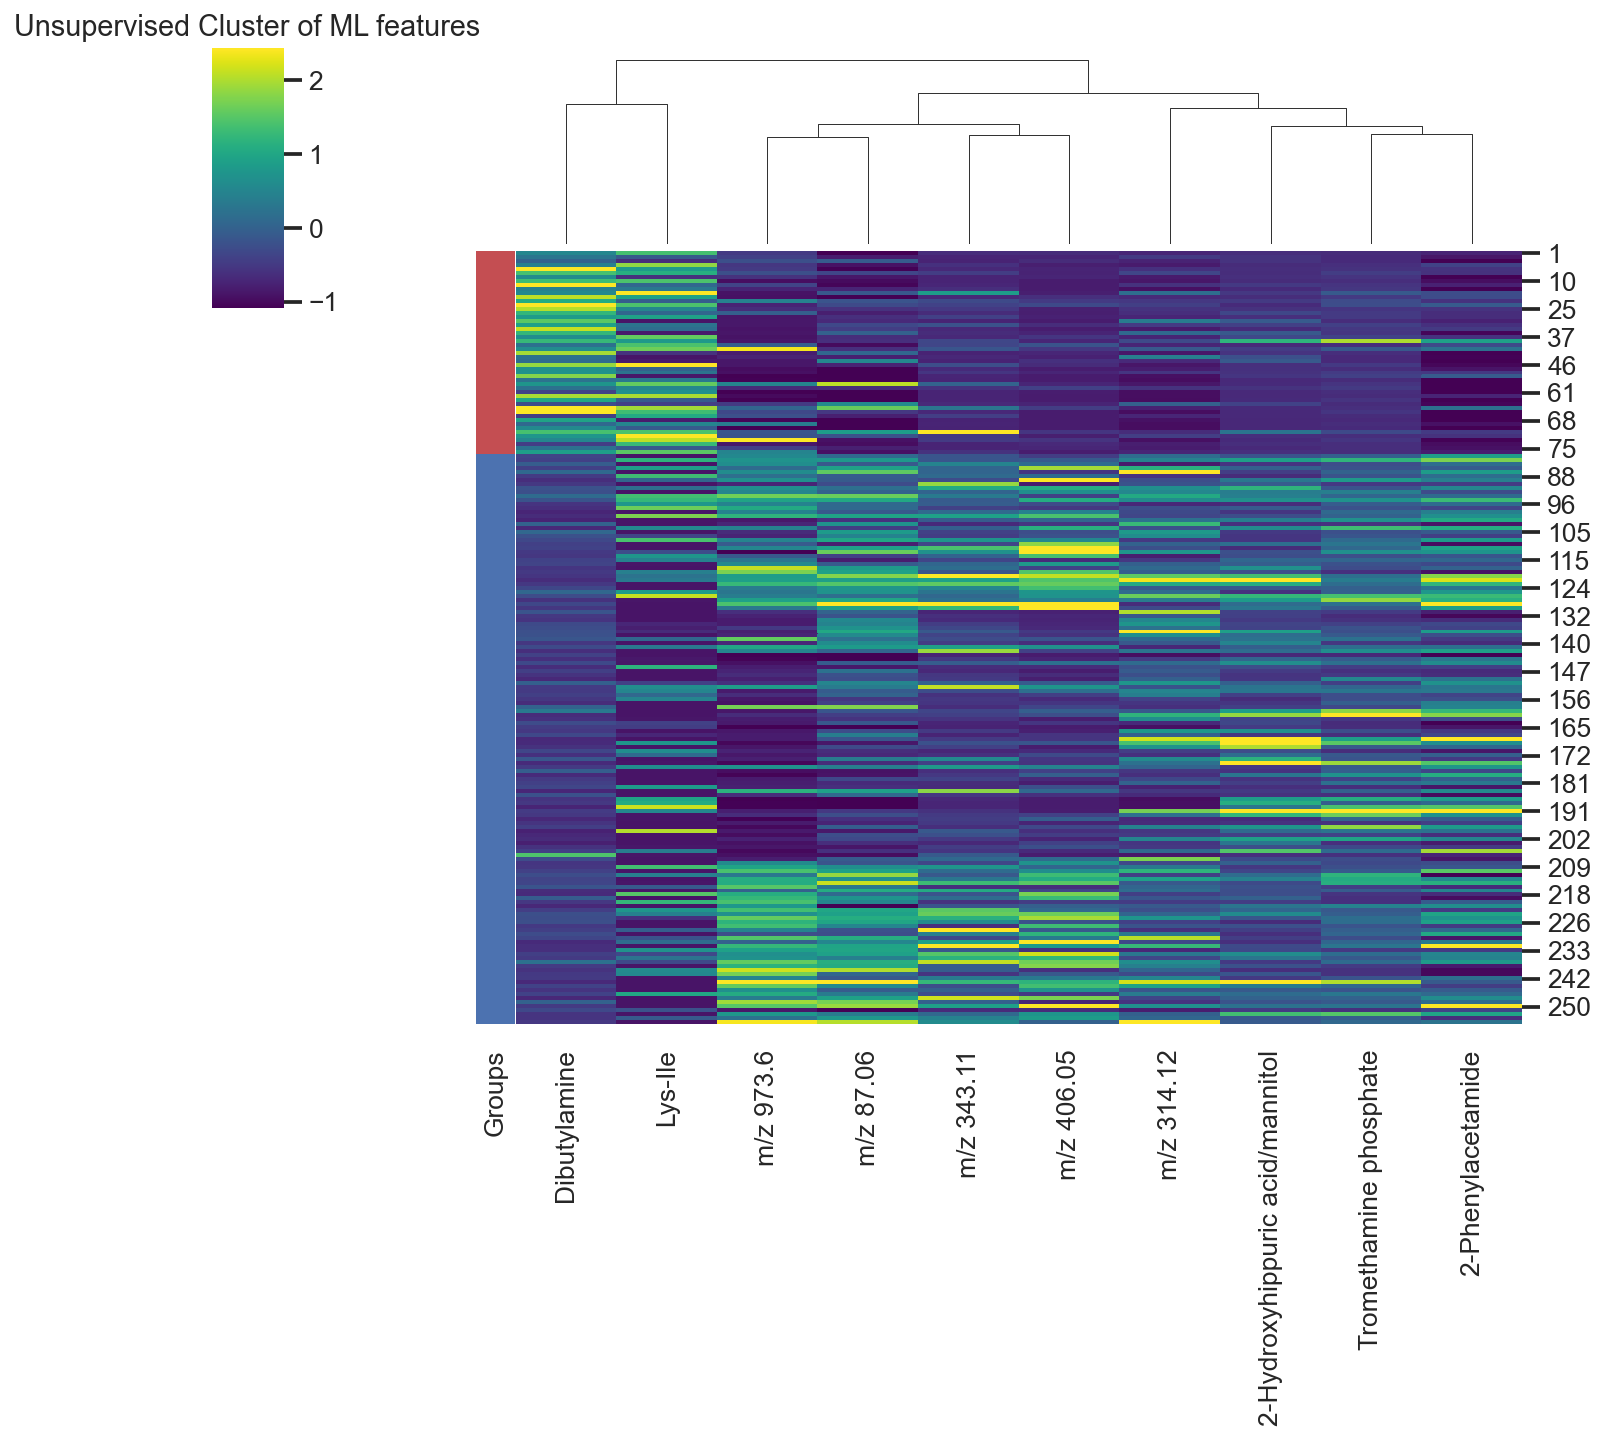

In [80]:
groups_two = biomarker2.pop('Groups')
biomarker2 = biomarker2.astype(float)
lut = dict(zip(groups_two.unique(), 'rbg'))
row_colors = groups_two.map(lut)
sns.clustermap(biomarker2, method="weighted", 
                   metric='euclidean', cmap="viridis", row_cluster=False, 
                   row_colors=row_colors, robust=True);
plt.title('Unsupervised Cluster of ML features');
# define biomarker dataframe again because of the .pop method
biomarker2 =  testcohort.iloc[:, group_loc].to_frame().join(MLfeatures2)